In [ ]:
'''
 * Copyright (c) 2008 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

##  Relation to K-means

The **K-means** algorithm can be seen as a special case of the **EM (Expectation-Maximization)** algorithm for Gaussian Mixture Models (GMMs). While the K-means algorithm assigns each data point to exactly one cluster (hard assignment), the EM algorithm provides a "soft" assignment, where each data point has a probability of belonging to each cluster based on the posterior probabilities.

## Gaussian Mixture Model with Identity Covariance

Consider a Gaussian Mixture Model where the covariance matrices of the mixture components are fixed and identical. Let the covariance matrix of each component be represented by $ \Sigma_k = \epsilon I $, where $ \epsilon $ is a variance parameter shared by all components and $ I $ is the identity matrix.

The probability density function for this Gaussian mixture is:

$$
p(x | \mu_k, \Sigma_k) = \frac{1}{\sqrt{(2 \pi \epsilon)^{D}}} \exp \left( -\frac{1}{2 \epsilon} (x - \mu_k)^2 \right)
$$

Here, $ D $ is the dimensionality of the data, and $ \mu_k $ is the mean of the $ k $-th Gaussian component.

## EM Algorithm Posterior (Responsibilities)

In the EM algorithm for Gaussian mixtures, the posterior probabilities (responsibilities) $ \gamma(z_{nk}) $ for the data point $ x_n $ in the $ k $-th cluster are given by:

$$
\gamma(z_{nk}) = \frac{\pi_k \exp\left( -\frac{(x_n - \mu_k)^2}{2 \epsilon} \right)}{\sum_{j} \pi_j \exp\left( -\frac{(x_n - \mu_j)^2}{2 \epsilon} \right)}
$$

Here, $ \pi_k $ are the mixing coefficients, and the term $ \exp\left( -\frac{(x_n - \mu_k)^2}{2 \epsilon} \right) $ represents the Gaussian likelihood of the data point $ x_n $ belonging to the $ k $-th component.

## Limit as $ \epsilon \to 0 $

As $\epsilon \to 0 $ the responsibilities $ \gamma(z_{nk}) $ approach a hard assignment. This happens because the denominator in the expression for $ \gamma(z_{nk}) $ is dominated by the term where $ (x_n - \mu_j)^2 $ is smallest, causing the responsibilities for all clusters except the closest one to approach zero.

In the limit, we have:

$$
\lim_{\epsilon \to 0} \gamma(z_{nk}) \to r_{nk}
$$

where $ r_{nk} $is defined as:

$$
r_{nk} = 
\begin{cases}
1 & \text{if } k = \arg\min_j (x_n - \mu_j)^2 \\
0 & \text{otherwise}
\end{cases}
$$

Thus, each data point is assigned to the cluster with the closest mean, just as in the K-means algorithm.

## Re-estimation of Parameters

In the EM algorithm, the update rule for the means $ \mu_k $ is:

$$
\mu_k^{\text{new}} = \frac{\sum_n \gamma(z_{nk}) x_n}{\sum_n \gamma(z_{nk})}
$$

In the limit as \( \epsilon \to 0 \), this reduces to the K-means update rule:

$$
\mu_k^{\text{new}} = \frac{\sum_{n: r_{nk}=1} x_n}{\sum_{n: r_{nk}=1} 1}
$$

Thus, in this limit, the EM algorithm's re-estimation of the means becomes equivalent to the K-means update.

## Mixing Coefficients

The re-estimation formula for the mixing coefficients $ \pi_k $ in the EM algorithm is:

$$
\pi_k^{\text{new}} = \frac{1}{N} \sum_n \gamma(z_{nk})
$$

In the limit as $ \epsilon \to 0 $, this simply gives the fraction of data points assigned to cluster $ k $, similar to the K-means algorithm where the mixing coefficients no longer play an active role.

## Log-Likelihood

Finally, the expected complete-data log-likelihood in the EM algorithm is:

$$
\mathbb{E}[ \ln p(X, Z | \mu, \Sigma, \pi) ] = \sum_{n=1}^N \sum_{k=1}^K \gamma(z_{nk}) \ln \left( \pi_k p(x_n | \mu_k, \Sigma_k) \right)
$$

In the limit as $ \epsilon \to 0 $, the log-likelihood becomes:

$$
\lim_{\epsilon \to 0} \mathbb{E}[ \ln p(X, Z | \mu, \Sigma, \pi) ] = - \sum_{n=1}^N \sum_{k=1}^K r_{nk} \frac{(x_n - \mu_k)^2}{2} + \text{const.}
$$

This shows that maximizing the expected log-likelihood in the EM algorithm becomes equivalent to minimizing the distortion measure $ J $ for the K-means algorithm:

$$
J = \sum_{k=1}^K \sum_{n: r_{nk} = 1} (x_n - \mu_k)^2
$$

## Conclusion

Thus, in the limit $ \epsilon \to 0 $, the EM algorithm for Gaussian mixtures reduces to the K-means algorithm, with hard assignments of data points to clusters and no covariance estimation. A hard-assignment version of the Gaussian mixture model with general covariance matrices is known as the **elliptical K-means** algorithm, as considered by Sung and Poggio (1994).


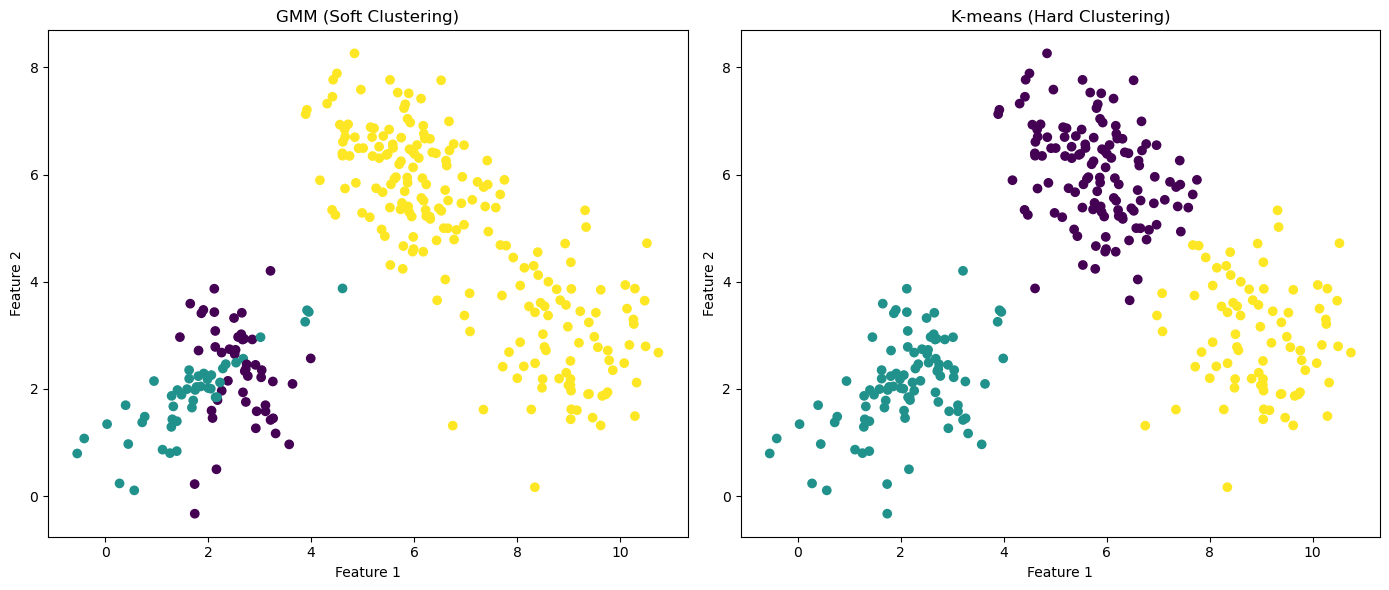

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal

# E-step: Calculate the responsibilities (gamma values)
def e_step(X, pi, mu, sigma, K):
    N = X.shape[0]
    gamma = np.zeros((N, K))
    
    for n in range(N):
        total_prob = 0
        for k in range(K):
            prob = pi[k] * multivariate_normal.pdf(X[n], mean=mu[k], cov=sigma[k])
            gamma[n, k] = prob
            total_prob += prob
        
        gamma[n, :] /= total_prob  # Normalize responsibilities
    
    return gamma

# M-step: Update the parameters (mu, sigma, pi)
def m_step(X, gamma, K):
    N, D = X.shape
    mu = np.zeros((K, D))
    sigma = np.zeros((K, D, D))
    pi = np.zeros(K)
    
    for k in range(K):
        Nk = np.sum(gamma[:, k])
        mu[k] = np.sum(gamma[:, k].reshape(-1, 1) * X, axis=0) / Nk
        diff = X - mu[k]
        sigma[k] = np.dot(gamma[:, k] * diff.T, diff) / Nk
        pi[k] = Nk / N
        
    return pi, mu, sigma

# EM algorithm for GMM
def em_algorithm(X, K, max_iter=100, tol=1e-6):
    N, D = X.shape
    pi = np.ones(K) / K  # Initial mixing coefficients
    mu = X[np.random.choice(N, K, False)]  # Initial means
    sigma = np.array([np.eye(D)] * K)  # Initial covariances (identity matrix)
    
    log_likelihoods = []
    
    for i in range(max_iter):
        # E-step
        gamma = e_step(X, pi, mu, sigma, K)
        
        # M-step
        pi, mu, sigma = m_step(X, gamma, K)
        
        # Log-likelihood computation
        log_likelihood = np.sum(np.log(np.sum([pi[k] * multivariate_normal.pdf(X, mean=mu[k], cov=sigma[k]) for k in range(K)], axis=0)))
        log_likelihoods.append(log_likelihood)
        
        # Check for convergence
        if i > 0 and abs(log_likelihood - log_likelihoods[-2]) < tol:
            break
    
    return pi, mu, sigma, gamma, log_likelihoods

# K-means algorithm
def k_means(X, K, max_iter=100, tol=1e-6):
    N, D = X.shape
    # Initialize centroids randomly
    centroids = X[np.random.choice(N, K, False)]
    prev_centroids = np.copy(centroids)
    labels = np.zeros(N)
    
    for i in range(max_iter):
        # Assign labels based on closest centroid
        dist = cdist(X, centroids, 'sqeuclidean')
        labels = np.argmin(dist, axis=1)
        
        # Update centroids
        for k in range(K):
            centroids[k] = np.mean(X[labels == k], axis=0)
        
        # Check for convergence
        if np.linalg.norm(centroids - prev_centroids) < tol:
            break
        prev_centroids = np.copy(centroids)
    
    return centroids, labels

# Generate synthetic data for demonstration
np.random.seed(0)
N = 300  # Number of data points
D = 2  # Number of features
K = 3  # Number of clusters

# Randomly generate centers and covariances for the Gaussian components
mu = np.array([[2, 2], [6, 6], [9, 3]])
sigma = np.array([[[1, 0.5], [0.5, 1]], [[1, -0.5], [-0.5, 1]], [[1, 0], [0, 1]]])
pi = np.array([0.3, 0.4, 0.3])

# Generate the data
X = np.zeros((N, D))
for i in range(N):
    k = np.random.choice(K, p=pi)
    X[i] = np.random.multivariate_normal(mu[k], sigma[k])

# Run EM Algorithm for GMM
pi_gmm, mu_gmm, sigma_gmm, gamma, log_likelihoods = em_algorithm(X, K)

# Run K-means
centroids_kmeans, labels_kmeans = k_means(X, K)

# Plot results for GMM (using soft assignments)
plt.figure(figsize=(14, 6))

# Plot GMM results (soft clustering)
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=np.argmax(gamma, axis=1), cmap='viridis')
plt.title("GMM (Soft Clustering)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

# Plot K-means results (hard clustering)
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=labels_kmeans, cmap='viridis')
plt.title("K-means (Hard Clustering)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# E-step: Calculate the responsibilities (gamma values)
def e_step(X, pi, mu, sigma, K):
    N = X.shape[0]
    gamma = np.zeros((N, K))
    
    for n in range(N):
        total_prob = 0
        for k in range(K):
            prob = pi[k] * gaussian_pdf(X[n], mu[k], sigma[k])
            gamma[n, k] = prob
            total_prob += prob
        
        gamma[n, :] /= total_prob  # Normalize responsibilities
    
    return gamma

# Gaussian PDF function
def gaussian_pdf(x, mu, sigma):
    d = len(x)
    diff = x - mu
    det_sigma = np.linalg.det(sigma)
    inv_sigma = np.linalg.inv(sigma)
    exponent = -0.5 * np.dot(np.dot(diff.T, inv_sigma), diff)
    coeff = 1 / (np.sqrt((2 * np.pi)**d * det_sigma))
    return coeff * np.exp(exponent)

# M-step: Update the parameters (mu, sigma, pi)
def m_step(X, gamma, K):
    N, D = X.shape
    mu = np.zeros((K, D))
    sigma = np.zeros((K, D, D))
    pi = np.zeros(K)
    
    for k in range(K):
        Nk = np.sum(gamma[:, k])
        mu[k] = np.sum(gamma[:, k].reshape(-1, 1) * X, axis=0) / Nk
        diff = X - mu[k]
        sigma[k] = np.dot(gamma[:, k] * diff.T, diff) / Nk
        pi[k] = Nk / N
        
    return pi, mu, sigma

# EM algorithm for GMM
def em_algorithm(X, K, max_iter=100, tol=1e-6):
    N, D = X.shape
    pi = np.ones(K) / K  # Initial mixing coefficients
    mu = X[np.random.choice(N, K, False)]  # Initial means
    sigma = np.array([np.eye(D)] * K)  # Initial covariances (identity matrix)
    
    log_likelihoods = []
    
    for i in range(max_iter):
        # E-step
        gamma = e_step(X, pi, mu, sigma, K)
        
        # M-step
        pi, mu, sigma = m_step(X, gamma, K)
        
        # Log-likelihood computation
        log_likelihood = np.sum(np.log(np.sum([pi[k] * gaussian_pdf(X, mu[k], sigma[k]) for k in range(K)], axis=0)))
        log_likelihoods.append(log_likelihood)
        
        # Check for convergence
        if i > 0 and abs(log_likelihood - log_likelihoods[-2]) < tol:
            break
    
    return pi, mu, sigma, gamma, log_likelihoods

# K-means algorithm
def k_means(X, K, max_iter=100, tol=1e-6):
    N, D = X.shape
    # Initialize centroids randomly
    centroids = X[np.random.choice(N, K, False)]
    prev_centroids = np.copy(centroids)
    labels = np.zeros(N)
    
    for i in range(max_iter):
        # Assign labels based on closest centroid
        dist = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(dist, axis=1)
        
        # Update centroids
        for k in range(K):
            centroids[k] = np.mean(X[labels == k], axis=0)
        
        # Check for convergence
        if np.linalg.norm(centroids - prev_centroids) < tol:
            break
        prev_centroids = np.copy(centroids)
    
    return centroids, labels

# Generate synthetic data for demonstration
np.random.seed(0)
N = 300  # Number of data points
D = 2  # Number of features
K = 3  # Number of clusters

# Randomly generate centers and covariances for the Gaussian components
mu = np.array([[2, 2], [6, 6], [9, 3]])
sigma = np.array([[[1, 0.5], [0.5, 1]], [[1, -0.5], [-0.5, 1]], [[1, 0], [0, 1]]])
pi = np.array([0.3, 0.4, 0.3])

# Generate the data
X = np.zeros((N, D))
for i in range(N):
    k = np.random.choice(K, p=pi)
    X[i] = np.random.multivariate_normal(mu[k], sigma[k])

# Run EM Algorithm for GMM
pi_gmm, mu_gmm, sigma_gmm, gamma, log_likelihoods = em_algorithm(X, K)

# Run K-means
centroids_kmeans, labels_kmeans = k_means(X, K)

# Plot results for GMM (using soft assignments)
plt.figure(figsize=(14, 6))

# Plot GMM results (soft clustering)
plt.subplot(1, 2, 1)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=np.argmax(gamma, axis=1), palette='viridis')
plt.title("GMM (Soft Clustering)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

# Plot K-means results (hard clustering)
plt.subplot(1, 2, 2)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels_kmeans, palette='viridis')
plt.title("K-means (Hard Clustering)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.tight_layout()
plt.show()


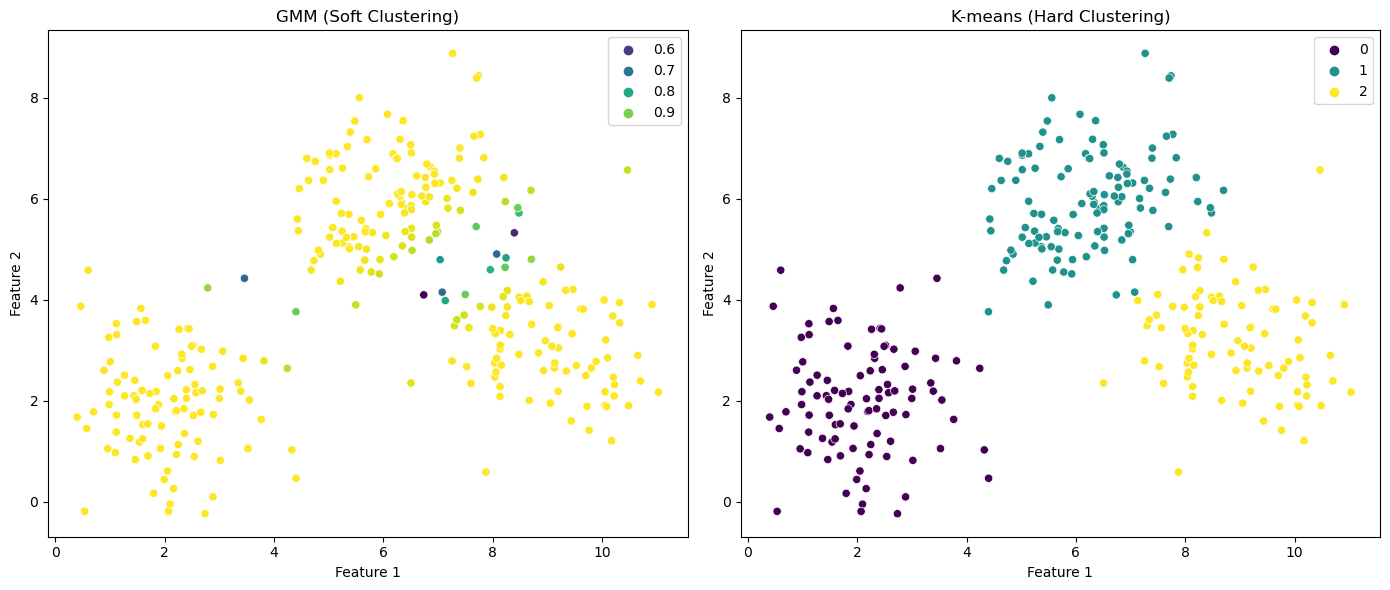

In [3]:
import math
import random
import seaborn as sns
import matplotlib.pyplot as plt

# E-step: Calculate the responsibilities (gamma values)
def e_step(X, pi, mu, sigma, K):
    N = len(X)
    gamma = []

    for n in range(N):
        responsibilities = []
        total_prob = 0
        for k in range(K):
            prob = pi[k] * gaussian_pdf(X[n], mu[k], sigma[k])
            responsibilities.append(prob)
            total_prob += prob
        
        # Normalize the responsibilities (soft assignment)
        responsibilities = [r / total_prob for r in responsibilities]
        gamma.append(responsibilities)
    
    return gamma

# Gaussian PDF function (manual computation)
def gaussian_pdf(x, mu, sigma):
    # Calculate the multivariate Gaussian PDF
    d = len(x)
    diff = [x[i] - mu[i] for i in range(d)]
    # Calculate the inverse of the covariance matrix and its determinant manually
    det_sigma = sigma[0][0] * sigma[1][1] - sigma[0][1] * sigma[1][0]
    inv_sigma = [[sigma[1][1], -sigma[0][1]], [-sigma[1][0], sigma[0][0]]]
    inv_sigma = [[val / det_sigma for val in row] for row in inv_sigma]
    
    exponent = -0.5 * sum(diff[i] * sum(inv_sigma[i][j] * diff[j] for j in range(d)) for i in range(d))
    coeff = 1 / (math.sqrt((2 * math.pi)**d * det_sigma))
    return coeff * math.exp(exponent)

# M-step: Update the parameters (mu, sigma, pi)
def m_step(X, gamma, K):
    N = len(X)
    D = len(X[0])
    
    pi = [0] * K
    mu = [[0] * D for _ in range(K)]
    sigma = [[[0] * D for _ in range(D)] for _ in range(K)]
    
    for k in range(K):
        Nk = sum(gamma[n][k] for n in range(N))
        # Update mu
        for i in range(D):
            mu[k][i] = sum(gamma[n][k] * X[n][i] for n in range(N)) / Nk
        
        # Update sigma
        for i in range(D):
            for j in range(D):
                sigma[k][i][j] = sum(gamma[n][k] * (X[n][i] - mu[k][i]) * (X[n][j] - mu[k][j]) for n in range(N)) / Nk
        
        # Update pi
        pi[k] = Nk / N
    
    return pi, mu, sigma

# EM algorithm for GMM
def em_algorithm(X, K, max_iter=100, tol=1e-6):
    N = len(X)
    D = len(X[0])
    
    # Initialize parameters
    pi = [1 / K] * K  # Initial mixing coefficients
    mu = [random.sample(X, 1)[0] for _ in range(K)]  # Initial means
    sigma = [[[1 if i == j else 0 for j in range(D)] for i in range(D)] for _ in range(K)]  # Identity covariance matrices
    
    log_likelihoods = []
    
    for i in range(max_iter):
        # E-step: Compute responsibilities (gamma)
        gamma = e_step(X, pi, mu, sigma, K)
        
        # M-step: Update parameters (mu, sigma, pi)
        pi, mu, sigma = m_step(X, gamma, K)
        
        # Compute log-likelihood
        log_likelihood = 0
        for n in range(N):
            prob = sum(pi[k] * gaussian_pdf(X[n], mu[k], sigma[k]) for k in range(K))
            log_likelihood += math.log(prob)
        
        log_likelihoods.append(log_likelihood)
        
        # Check for convergence
        if i > 0 and abs(log_likelihood - log_likelihoods[-2]) < tol:
            break
    
    return pi, mu, sigma, gamma, log_likelihoods

# K-means algorithm
def k_means(X, K, max_iter=100, tol=1e-6):
    N = len(X)
    D = len(X[0])
    
    # Initialize centroids randomly
    centroids = [random.sample(X, 1)[0] for _ in range(K)]
    prev_centroids = [centroid[:] for centroid in centroids]
    labels = [0] * N
    
    for i in range(max_iter):
        # Assign labels based on closest centroid
        dist = [[sum((X[n][d] - centroids[k][d])**2 for d in range(D)) for k in range(K)] for n in range(N)]
        labels = [min(range(K), key=lambda k: dist[n][k]) for n in range(N)]
        
        # Update centroids
        for k in range(K):
            assigned_points = [X[n] for n in range(N) if labels[n] == k]
            if assigned_points:
                centroids[k] = [sum(point[d] for point in assigned_points) / len(assigned_points) for d in range(D)]
        
        # Check for convergence
        if all(all(abs(centroids[k][d] - prev_centroids[k][d]) < tol for d in range(D)) for k in range(K)):
            break
        prev_centroids = [centroid[:] for centroid in centroids]
    
    return centroids, labels

# Generate synthetic data for demonstration
random.seed(0)
N = 300  # Number of data points
D = 2  # Number of features
K = 3  # Number of clusters

# Randomly generate centers and covariances for the Gaussian components
mu = [[2, 2], [6, 6], [9, 3]]
sigma = [[[1, 0.5], [0.5, 1]], [[1, -0.5], [-0.5, 1]], [[1, 0], [0, 1]]]
pi = [0.3, 0.4, 0.3]

# Generate the data
X = []
for i in range(N):
    k = random.choices(range(K), pi)[0]
    X.append([random.gauss(mu[k][0], math.sqrt(sigma[k][0][0])), random.gauss(mu[k][1], math.sqrt(sigma[k][1][1]))])

# Run EM Algorithm for GMM
pi_gmm, mu_gmm, sigma_gmm, gamma, log_likelihoods = em_algorithm(X, K)

# Run K-means
centroids_kmeans, labels_kmeans = k_means(X, K)

# Plot results for GMM (using soft assignments)
plt.figure(figsize=(14, 6))

# Plot GMM results (soft clustering)
plt.subplot(1, 2, 1)
sns.scatterplot(x=[x[0] for x in X], y=[x[1] for x in X], hue=[max(g) for g in gamma], palette='viridis')
plt.title("GMM (Soft Clustering)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

# Plot K-means results (hard clustering)
plt.subplot(1, 2, 2)
sns.scatterplot(x=[x[0] for x in X], y=[x[1] for x in X], hue=labels_kmeans, palette='viridis')
plt.title("K-means (Hard Clustering)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.tight_layout()
plt.show()


##  Mixtures of Bernoulli Distributions

In this section, we explore mixtures of discrete binary variables described by Bernoulli distributions. This model is often referred to as **Latent Class Analysis (LCA)** and has important applications in various fields such as mixture modeling, clustering, and hidden Markov models. The goal is to maximize the likelihood function for a mixture of Bernoulli distributions using the **Expectation-Maximization (EM)** algorithm.

### Bernoulli Distribution

Consider a set of $ D $ binary variables $ x_i $, where $ i = 1, \dots, D $. Each variable $ x_i $ is governed by a Bernoulli distribution with parameter $ \mu_i $, such that:

$$ p(x_i | \mu_i) = \mu_i^{x_i} (1 - \mu_i)^{(1 - x_i)} $$

The complete joint likelihood for \( x = (x_1, \dots, x_D)^T \) is:

$$ p(x | \mu) = \prod_{i=1}^{D} \mu_i^{x_i} (1 - \mu_i)^{(1 - x_i)} $$

### Mixture of Bernoulli Distributions

Now, consider a finite mixture of these Bernoulli distributions, where the mixture has $ K $ components. The mixture model is given by:

$$ p(x | \mu, \pi) = \sum_{k=1}^{K} \pi_k p(x | \mu_k) $$

where:

$$ p(x | \mu_k) = \prod_{i=1}^{D} \mu_{ki}^{x_i} (1 - \mu_{ki})^{(1 - x_i)} $$

Here, $ \mu_k = (\mu_{k1}, \dots, \mu_{kD})^T $ represents the parameters of the $ k $-th Bernoulli component, and $ \pi_k $ represents the mixing coefficient for the $ k $-th component, with:

$$ \sum_{k=1}^{K} \pi_k = 1 $$

### Mean and Covariance of the Mixture

The mean and covariance of the mixture distribution are as follows:

**Mean:**

$$ \mathbb{E}[x] = \sum_{k=1}^{K} \pi_k \mu_k $$

**Covariance:**

$$ \text{cov}[x] = \sum_{k=1}^{K} \pi_k \Sigma_k + \mu_k \mu_k^T - \mathbb{E}[x] \mathbb{E}[x]^T $$

where $ \Sigma_k = \text{diag}(\mu_{k1}(1 - \mu_{k1}), \dots, \mu_{kD}(1 - \mu_{kD})) $ is the covariance matrix for the $ k $-th component.

### Log-Likelihood Function

Given a data set $ X = \{ x_1, \dots, x_N \} $, the log-likelihood for the mixture of Bernoulli distributions is:

$$ \ln p(X | \mu, \pi) = \sum_{n=1}^{N} \ln \left( \sum_{k=1}^{K} \pi_k p(x_n | \mu_k) \right) $$

This log-likelihood function involves a summation inside the logarithm, which complicates the maximization, making a closed-form solution unavailable.

### Expectation-Maximization (EM) Algorithm

To maximize the log-likelihood, we introduce a latent variable $ z_n $, which indicates which mixture component generated the data point $ x_n $. The EM algorithm iteratively performs the following steps:

#### E-Step (Expectation)

In the E-step, we compute the posterior probabilities (or responsibilities) $ \gamma(z_{nk}) $ that data point $ x_n $ was generated by the $ k $-th component:

$$ \gamma(z_{nk}) = \frac{\pi_k p(x_n | \mu_k)}{\sum_{k=1}^{K} \pi_k p(x_n | \mu_k)} $$

#### M-Step (Maximization)

In the M-step, we update the parameters $ \mu_k $ and $ \pi_k $ by maximizing the expected complete log-likelihood:

- Update the mixing coefficients $ \pi_k $:

$$ \pi_k = \frac{1}{N} \sum_{n=1}^{N} \gamma(z_{nk}) $$

- Update the parameters \( \mu_k \):

$$ \mu_k = \frac{\sum_{n=1}^{N} \gamma(z_{nk}) x_n}{\sum_{n=1}^{N} \gamma(z_{nk})} $$

### Conclusion

By iterating between the E-step and M-step, the EM algorithm will converge to a local maximum of the log-likelihood function. The learned mixture model can then be used for tasks such as clustering, density estimation, and classification.



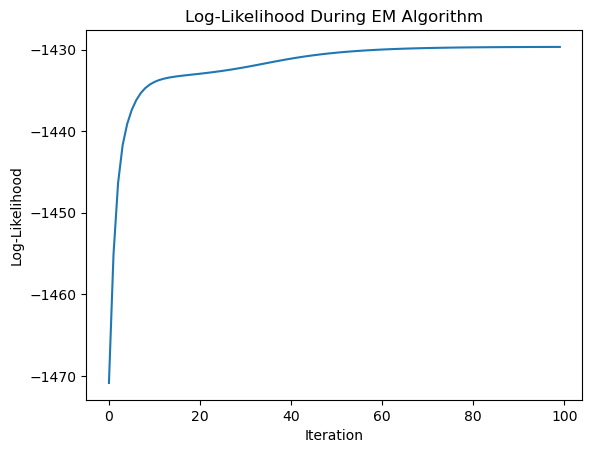

In [4]:
import random
import math
import seaborn as sns
import matplotlib.pyplot as plt

# Data generation (Bernoulli mixture)
def generate_data(N, K, D, pi, mu):
    data = []
    for _ in range(N):
        # Choose a component based on pi
        component = random.choices(range(K), pi)[0]
        # Generate a data point based on the selected component's mean
        x = [1 if random.random() < mu[component][i] else 0 for i in range(D)]
        data.append(x)
    return data

# E-step: Compute responsibilities (gamma)
def e_step(X, pi, mu, K):
    responsibilities = []
    for x in X:
        gamma = []
        for k in range(K):
            prob = pi[k]
            for i in range(len(x)):
                prob *= mu[k][i]**x[i] * (1 - mu[k][i])**(1 - x[i])
            gamma.append(prob)
        total_prob = sum(gamma)
        responsibilities.append([g / total_prob for g in gamma])  # Normalize to get the responsibilities
    return responsibilities

# M-step: Update parameters (mu and pi)
def m_step(X, gamma, K, D):
    N = len(X)
    # Update pi
    pi = [sum(g[k] for g in gamma) / N for k in range(K)]
    
    # Update mu
    mu = []
    for k in range(K):
        numerator = [0] * D
        denominator = 0
        for n in range(N):
            for i in range(D):
                numerator[i] += gamma[n][k] * X[n][i]
            denominator += gamma[n][k]
        mu_k = [n / denominator for n in numerator]
        mu.append(mu_k)
    
    return pi, mu

# Log-likelihood function
def log_likelihood(X, pi, mu, K):
    log_likelihood = 0
    for x in X:
        total_prob = 0
        for k in range(K):
            prob = pi[k]
            for i in range(len(x)):
                prob *= mu[k][i]**x[i] * (1 - mu[k][i])**(1 - x[i])
            total_prob += prob
        log_likelihood += math.log(total_prob)
    return log_likelihood

# EM algorithm for Mixture of Bernoulli distributions
def em_algorithm(X, K, max_iter=100, tol=1e-6):
    N = len(X)
    D = len(X[0])  # Dimension of each data point
    
    # Initialize parameters
    pi = [1 / K] * K
    mu = [[random.random() for _ in range(D)] for _ in range(K)]  # Random initialization
    
    log_likelihoods = []
    
    for iteration in range(max_iter):
        # E-step: Compute responsibilities (gamma)
        gamma = e_step(X, pi, mu, K)
        
        # M-step: Update parameters (mu and pi)
        pi, mu = m_step(X, gamma, K, D)
        
        # Calculate log-likelihood
        log_likelihood_val = log_likelihood(X, pi, mu, K)
        log_likelihoods.append(log_likelihood_val)
        
        # Check for convergence (if log-likelihood change is small)
        if iteration > 0 and abs(log_likelihood_val - log_likelihoods[-2]) < tol:
            print(f"Converged at iteration {iteration}")
            break
    
    return pi, mu, log_likelihoods

# Generate synthetic data
N = 500  # Number of data points
K = 2  # Number of components (clusters)
D = 5  # Number of features (binary variables)
pi_true = [0.6, 0.4]  # Mixing coefficients
mu_true = [[0.9, 0.1, 0.8, 0.7, 0.9],  # Mean for cluster 1
           [0.3, 0.2, 0.4, 0.3, 0.5]]  # Mean for cluster 2

X = generate_data(N, K, D, pi_true, mu_true)

# Run the EM algorithm
pi, mu, log_likelihoods = em_algorithm(X, K)

# Plot the log-likelihood over iterations
plt.plot(log_likelihoods)
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood During EM Algorithm')
plt.show()

# Visualizing the final clusters (only works if D=2)
if D == 2:
    sns.scatterplot(x=[x[0] for x in X], y=[x[1] for x in X], hue=[max(g) for g in e_step(X, pi, mu, K)], palette="viridis")
    plt.title('Final Clustering Results')
    plt.show()



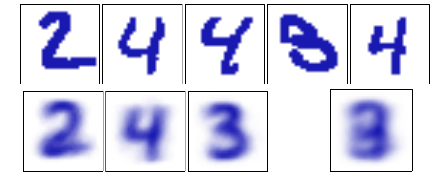

Fig.10 Illustration of the Bernoulli mixture model in which the top row shows examples from the digits data set after converting the pixel values from grey scale to binary using a threshold of 0.5. On the bottom row the ﬁrst three images show the parameters µki for each of the three components in the mixture model. As a comparison, we also ﬁt the same data set using a single multivariate Bernoulli distribution, again using maximum likelihood. This amounts to simply averaging the counts in each pixel and is shown by the right-most image on the bottom row.

## Bernoulli Mixture Model and EM Algorithm

In this section, we derive and implement the Expectation-Maximization (EM) algorithm for a mixture of Bernoulli distributions, a discrete model for binary data.

### Model Description

Given a set of $ D $ binary variables $ x = (x_1, x_2, \dots, x_D)^T $, each governed by a Bernoulli distribution with parameter $ \mu_i $, the probability of observing $ x $ given parameters $ \mu $ is:

$$ p(x | \mu) = \prod_{i=1}^{D} \mu_i^{x_i} (1 - \mu_i)^{1 - x_i} $$

where $ \mu = (\mu_1, \mu_2, \dots, \mu_D)^T $.

Now consider a mixture of $ K $ Bernoulli distributions, where the probability of $ x $ is given by:

$$ p(x | \mu, \pi) = \sum_{k=1}^{K} \pi_k p(x | \mu_k) $$

where $ \pi_k $ is the mixing coefficient for the $ k $-th component, and $ \mu_k $ is the parameter vector for the Bernoulli distribution of the $ k $-th component.

### Latent Variable Model

Introduce a latent variable $ z = (z_1, z_2, \dots, z_K)^T $ for each data point $ x_n $, where each $ z_k $ is a binary variable indicating which component generated $ x_n $. We have:

$$ p(x | z, \mu) = p(x | \mu_k)^{z_k} $$

and the prior distribution for the latent variables $ z $ is:

$$ p(z | \pi) = \prod_{k=1}^{K} \pi_k^{z_k} $$

### Complete Data Log-Likelihood

The complete-data log-likelihood is:

$$ \ln p(X, Z | \mu, \pi) = \sum_{n=1}^{N} \sum_{k=1}^{K} z_{nk} \left[ \ln \pi_k + \sum_{i=1}^{D} \left( x_{ni} \ln \mu_{ki} + (1 - x_{ni}) \ln(1 - \mu_{ki}) \right) \right] $$

### E-Step: Posterior Probabilities (Responsibilities)

In the E-step, we compute the responsibilities $ \gamma(z_{nk}) $, which is the posterior probability that component $ k $ generated data point $ x_n $. This is computed using Bayes' theorem:

$$ \gamma(z_{nk}) = \frac{\pi_k p(x_n | \mu_k)}{\sum_{j=1}^{K} \pi_j p(x_n | \mu_j)} $$

### M-Step: Parameter Update

In the M-step, we update the parameters $ \mu_k $ and $ \pi_k $ by maximizing the expected complete-data log-likelihood.

1. **Update of $ \mu_k $**:
   The mean $ \mu_k $ is updated as the weighted average of the data points, where the weights are the responsibilities:

   $$ \mu_k = \frac{\sum_{n=1}^{N} \gamma(z_{nk}) x_n}{\sum_{n=1}^{N} \gamma(z_{nk})} $$

2. **Update of $ \pi_k $**:
   The mixing coefficients $ \pi_k $ are updated based on the effective number of points assigned to each cluster:

   $$ \pi_k = \frac{1}{N} \sum_{n=1}^{N} \gamma(z_{nk}) $$

### EM Algorithm

The EM algorithm alternates between the E-step and M-step until convergence. The steps are as follows:

1. **E-step**: Calculate the responsibilities $ \gamma(z_{nk}) $ for each data point $ x_n $.
2. **M-step**: Update the parameters $ \mu_k $ and $ \pi_k $ based on the responsibilities.



Converged at iteration 93


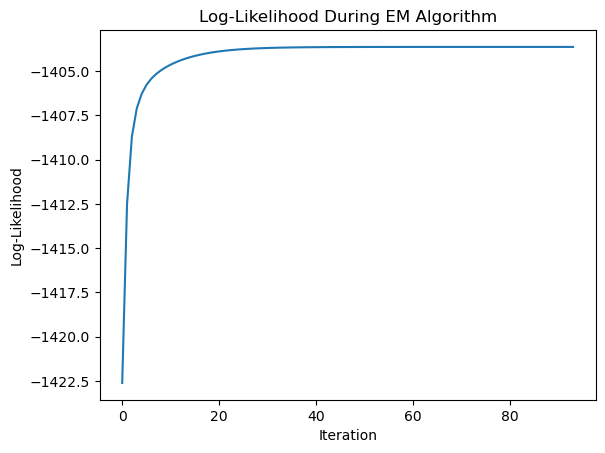

In [6]:
### Python Implementation

import random
import math
import seaborn as sns
import matplotlib.pyplot as plt

# Data generation (Bernoulli mixture)
def generate_data(N, K, D, pi, mu):
    data = []
    for _ in range(N):
        # Choose a component based on pi
        component = random.choices(range(K), pi)[0]
        # Generate a data point based on the selected component's mean
        x = [1 if random.random() < mu[component][i] else 0 for i in range(D)]
        data.append(x)
    return data

# E-step: Compute responsibilities (gamma)
def e_step(X, pi, mu, K):
    responsibilities = []
    for x in X:
        gamma = []
        for k in range(K):
            prob = pi[k]
            for i in range(len(x)):
                prob *= mu[k][i]**x[i] * (1 - mu[k][i])**(1 - x[i])
            gamma.append(prob)
        total_prob = sum(gamma)
        responsibilities.append([g / total_prob for g in gamma])  # Normalize to get the responsibilities
    return responsibilities

# M-step: Update parameters (mu and pi)
def m_step(X, gamma, K, D):
    N = len(X)
    # Update pi
    pi = [sum(g[k] for g in gamma) / N for k in range(K)]
    
    # Update mu
    mu = []
    for k in range(K):
        numerator = [0] * D
        denominator = 0
        for n in range(N):
            for i in range(D):
                numerator[i] += gamma[n][k] * X[n][i]
            denominator += gamma[n][k]
        mu_k = [n / denominator for n in numerator]
        mu.append(mu_k)
    
    return pi, mu

# Log-likelihood function
def log_likelihood(X, pi, mu, K):
    log_likelihood = 0
    for x in X:
        total_prob = 0
        for k in range(K):
            prob = pi[k]
            for i in range(len(x)):
                prob *= mu[k][i]**x[i] * (1 - mu[k][i])**(1 - x[i])
            total_prob += prob
        log_likelihood += math.log(total_prob)
    return log_likelihood

# EM algorithm for Mixture of Bernoulli distributions
def em_algorithm(X, K, max_iter=100, tol=1e-6):
    N = len(X)
    D = len(X[0])  # Dimension of each data point
    
    # Initialize parameters
    pi = [1 / K] * K
    mu = [[random.random() for _ in range(D)] for _ in range(K)]  # Random initialization
    
    log_likelihoods = []
    
    for iteration in range(max_iter):
        # E-step: Compute responsibilities (gamma)
        gamma = e_step(X, pi, mu, K)
        
        # M-step: Update parameters (mu and pi)
        pi, mu = m_step(X, gamma, K, D)
        
        # Calculate log-likelihood
        log_likelihood_val = log_likelihood(X, pi, mu, K)
        log_likelihoods.append(log_likelihood_val)
        
        # Check for convergence (if log-likelihood change is small)
        if iteration > 0 and abs(log_likelihood_val - log_likelihoods[-2]) < tol:
            print(f"Converged at iteration {iteration}")
            break
    
    return pi, mu, log_likelihoods

# Generate synthetic data
N = 500  # Number of data points
K = 2  # Number of components (clusters)
D = 5  # Number of features (binary variables)
pi_true = [0.6, 0.4]  # Mixing coefficients
mu_true = [[0.9, 0.1, 0.8, 0.7, 0.9],  # Mean for cluster 1
           [0.3, 0.2, 0.4, 0.3, 0.5]]  # Mean for cluster 2

X = generate_data(N, K, D, pi_true, mu_true)

# Run the EM algorithm
pi, mu, log_likelihoods = em_algorithm(X, K)

# Plot the log-likelihood over iterations
plt.plot(log_likelihoods)
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood During EM Algorithm')
plt.show()

# Visualizing the final clusters (only works if D=2)
if D == 2:
    sns.scatterplot(x=[x[0] for x in X], y=[x[1] for x in X], hue=[max(g) for g in e_step(X, pi, mu, K)], palette="viridis")
    plt.title('Final Clustering Results')
    plt.show()



## Bernoulli Mixture Model and EM Algorithm

In this section, we derive and implement the Expectation-Maximization (EM) algorithm for a mixture of Bernoulli distributions, a discrete model for binary data.

### Model Description

Given a set of $ D $ binary variables $ x = (x_1, x_2, \dots, x_D)^T $, each governed by a Bernoulli distribution with parameter $ \mu_i $, the probability of observing $ x $ given parameters $ \mu $ is:

$$ p(x | \mu) = \prod_{i=1}^{D} \mu_i^{x_i} (1 - \mu_i)^{1 - x_i} $$

where $ \mu = (\mu_1, \mu_2, \dots, \mu_D)^T $.

Now consider a mixture of $ K $ Bernoulli distributions, where the probability of $ x $ is given by:

$$ p(x | \mu, \pi) = \sum_{k=1}^{K} \pi_k p(x | \mu_k) $$

where $ \pi_k $ is the mixing coefficient for the $ k $-th component, and $ \mu_k $ is the parameter vector for the Bernoulli distribution of the $ k $-th component.

### Latent Variable Model

Introduce a latent variable $ z = (z_1, z_2, \dots, z_K)^T $ for each data point $ x_n $, where each $ z_k $ is a binary variable indicating which component generated $ x_n $. We have:

$$ p(x | z, \mu) = p(x | \mu_k)^{z_k} $$

and the prior distribution for the latent variables $ z $ is:

$$ p(z | \pi) = \prod_{k=1}^{K} \pi_k^{z_k} $$

### Complete Data Log-Likelihood

The complete-data log-likelihood is:

$$ \ln p(X, Z | \mu, \pi) = \sum_{n=1}^{N} \sum_{k=1}^{K} z_{nk} \left[ \ln \pi_k + \sum_{i=1}^{D} \left( x_{ni} \ln \mu_{ki} + (1 - x_{ni}) \ln(1 - \mu_{ki}) \right) \right] $$

### E-Step: Posterior Probabilities (Responsibilities)

In the E-step, we compute the responsibilities $ \gamma(z_{nk}) $, which is the posterior probability that component $ k $ generated data point $ x_n $. This is computed using Bayes' theorem:

$$ \gamma(z_{nk}) = \frac{\pi_k p(x_n | \mu_k)}{\sum_{j=1}^{K} \pi_j p(x_n | \mu_j)} $$

### M-Step: Parameter Update

In the M-step, we update the parameters $ \mu_k $ and $ \pi_k $ by maximizing the expected complete-data log-likelihood.

1. **Update of $ \mu_k $**:
   The mean $ \mu_k $ is updated as the weighted average of the data points, where the weights are the responsibilities:

   $$ \mu_k = \frac{\sum_{n=1}^{N} \gamma(z_{nk}) x_n}{\sum_{n=1}^{N} \gamma(z_{nk})} $$

2. **Update of $ \pi_k $**:
   The mixing coefficients $ \pi_k $ are updated based on the effective number of points assigned to each cluster:

   $$ \pi_k = \frac{1}{N} \sum_{n=1}^{N} \gamma(z_{nk}) $$

### EM Algorithm

The EM algorithm alternates between the E-step and M-step until convergence. The steps are as follows:

1. **E-step**: Calculate the responsibilities $ \gamma(z_{nk}) $ for each data point $ x_n $.
2. **M-step**: Update the parameters $ \mu_k $ and $ \pi_k $ based on the responsibilities.





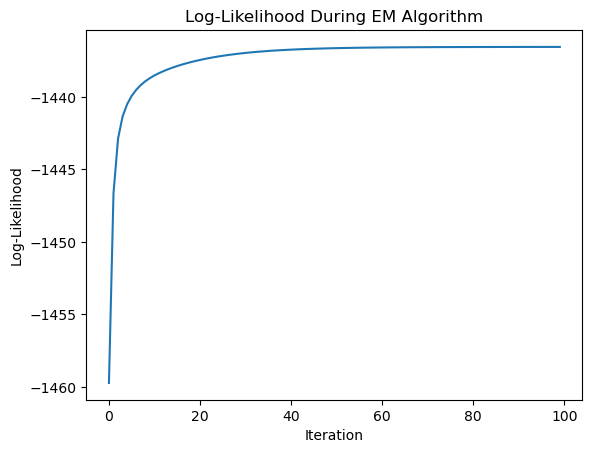

In [7]:
### Python Implementation


import random
import math
import seaborn as sns
import matplotlib.pyplot as plt

# Data generation (Bernoulli mixture)
def generate_data(N, K, D, pi, mu):
    data = []
    for _ in range(N):
        # Choose a component based on pi
        component = random.choices(range(K), pi)[0]
        # Generate a data point based on the selected component's mean
        x = [1 if random.random() < mu[component][i] else 0 for i in range(D)]
        data.append(x)
    return data

# E-step: Compute responsibilities (gamma)
def e_step(X, pi, mu, K):
    responsibilities = []
    for x in X:
        gamma = []
        for k in range(K):
            prob = pi[k]
            for i in range(len(x)):
                prob *= mu[k][i]**x[i] * (1 - mu[k][i])**(1 - x[i])
            gamma.append(prob)
        total_prob = sum(gamma)
        responsibilities.append([g / total_prob for g in gamma])  # Normalize to get the responsibilities
    return responsibilities

# M-step: Update parameters (mu and pi)
def m_step(X, gamma, K, D):
    N = len(X)
    # Update pi
    pi = [sum(g[k] for g in gamma) / N for k in range(K)]
    
    # Update mu
    mu = []
    for k in range(K):
        numerator = [0] * D
        denominator = 0
        for n in range(N):
            for i in range(D):
                numerator[i] += gamma[n][k] * X[n][i]
            denominator += gamma[n][k]
        mu_k = [n / denominator for n in numerator]
        mu.append(mu_k)
    
    return pi, mu

# Log-likelihood function
def log_likelihood(X, pi, mu, K):
    log_likelihood = 0
    for x in X:
        total_prob = 0
        for k in range(K):
            prob = pi[k]
            for i in range(len(x)):
                prob *= mu[k][i]**x[i] * (1 - mu[k][i])**(1 - x[i])
            total_prob += prob
        log_likelihood += math.log(total_prob)
    return log_likelihood

# EM algorithm for Mixture of Bernoulli distributions
def em_algorithm(X, K, max_iter=100, tol=1e-6):
    N = len(X)
    D = len(X[0])  # Dimension of each data point
    
    # Initialize parameters
    pi = [1 / K] * K
    mu = [[random.random() for _ in range(D)] for _ in range(K)]  # Random initialization
    
    log_likelihoods = []
    
    for iteration in range(max_iter):
        # E-step: Compute responsibilities (gamma)
        gamma = e_step(X, pi, mu, K)
        
        # M-step: Update parameters (mu and pi)
        pi, mu = m_step(X, gamma, K, D)
        
        # Calculate log-likelihood
        log_likelihood_val = log_likelihood(X, pi, mu, K)
        log_likelihoods.append(log_likelihood_val)
        
        # Check for convergence (if log-likelihood change is small)
        if iteration > 0 and abs(log_likelihood_val - log_likelihoods[-2]) < tol:
            print(f"Converged at iteration {iteration}")
            break
    
    return pi, mu, log_likelihoods

# Generate synthetic data
N = 500  # Number of data points
K = 2  # Number of components (clusters)
D = 5  # Number of features (binary variables)
pi_true = [0.6, 0.4]  # Mixing coefficients
mu_true = [[0.9, 0.1, 0.8, 0.7, 0.9],  # Mean for cluster 1
           [0.3, 0.2, 0.4, 0.3, 0.5]]  # Mean for cluster 2

X = generate_data(N, K, D, pi_true, mu_true)

# Run the EM algorithm
pi, mu, log_likelihoods = em_algorithm(X, K)

# Plot the log-likelihood over iterations
plt.plot(log_likelihoods)
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood During EM Algorithm')
plt.show()

# Visualizing the final clusters (only works if D=2)
if D == 2:
    sns.scatterplot(x=[x[0] for x in X], y=[x[1] for x in X], hue=[max(g) for g in e_step(X, pi, mu, K)], palette="viridis")
    plt.title('Final Clustering Results')
    plt.show()

In [8]:
import numpy as np

class BernoulliMixtureModel:
    def __init__(self, K, max_iter=100, tol=1e-6):
        self.K = K  # Number of components
        self.max_iter = max_iter  # Maximum number of EM iterations
        self.tol = tol  # Convergence tolerance
    
    def fit(self, X):
        """
        Fit the Bernoulli Mixture Model to data using the EM algorithm.
        
        X : array-like, shape (N, D)
            The input binary data, where N is the number of data points
            and D is the dimensionality (number of features).
        """
        N, D = X.shape  # Number of data points and number of features
        
        # Initialize the parameters
        self.pi = np.ones(self.K) / self.K  # Mixing coefficients (π_k)
        self.mu = np.random.rand(self.K, D)  # Component parameters (μ_k)
        
        # Ensure that mu is in the range [0, 1] (valid for Bernoulli distribution)
        self.mu = np.clip(self.mu, 0.01, 0.99)

        # EM algorithm
        log_likelihoods = []

        for i in range(self.max_iter):
            # E-step: Calculate responsibilities (gamma)
            gamma = self._e_step(X)
            
            # M-step: Update parameters (mu, pi)
            self._m_step(X, gamma)
            
            # Compute log-likelihood to check for convergence
            log_likelihood = self._compute_log_likelihood(X)
            log_likelihoods.append(log_likelihood)
            
            # Check for convergence (if log-likelihood change is below tolerance)
            if i > 0 and np.abs(log_likelihood - log_likelihoods[-2]) < self.tol:
                print(f"Converged at iteration {i + 1}")
                break
        return self
    
    def _e_step(self, X):
        """
        E-step: Calculate the responsibilities (gamma).
        """
        N = X.shape[0]
        gamma = np.zeros((N, self.K))
        
        # Compute the probability of each data point for each component
        for k in range(self.K):
            # Bernoulli likelihood for component k
            likelihood = np.prod(self.mu[k] ** X * (1 - self.mu[k]) ** (1 - X), axis=1)
            gamma[:, k] = self.pi[k] * likelihood
        
        # Normalize to get responsibilities (gamma)
        gamma = gamma / np.sum(gamma, axis=1, keepdims=True)
        
        return gamma
    
    def _m_step(self, X, gamma):
        """
        M-step: Update the parameters (mu_k and pi_k).
        """
        N = X.shape[0]
        
        # Update mu_k (component means)
        for k in range(self.K):
            self.mu[k] = np.sum(gamma[:, k][:, np.newaxis] * X, axis=0) / np.sum(gamma[:, k])
        
        # Update pi_k (mixing coefficients)
        self.pi = np.sum(gamma, axis=0) / N
    
    def _compute_log_likelihood(self, X):
        """
        Compute the log-likelihood of the data given the current parameters.
        """
        N = X.shape[0]
        log_likelihood = 0
        
        # Compute the log-likelihood for each data point
        for n in range(N):
            likelihood = 0
            for k in range(self.K):
                likelihood += self.pi[k] * np.prod(self.mu[k] ** X[n] * (1 - self.mu[k]) ** (1 - X[n]))
            log_likelihood += np.log(likelihood)
        
        return log_likelihood

    def predict(self, X):
        """
        Predict the component assignments for each data point.
        """
        gamma = self._e_step(X)
        return np.argmax(gamma, axis=1)

# Example usage:
if __name__ == "__main__":
    # Generate synthetic binary data for testing
    np.random.seed(42)
    N, D, K = 500, 10, 3  # 500 data points, 10 features, 3 components
    X = np.random.binomial(1, 0.5, size=(N, D))  # Binary data

    # Fit the Bernoulli Mixture Model
    model = BernoulliMixtureModel(K=K)
    model.fit(X)
    
    # Make predictions (component assignments for each data point)
    predictions = model.predict(X)
    
    # Output the learned parameters
    print("Mixing coefficients (pi):", model.pi)
    print("Component means (mu):", model.mu)
    print("Predictions for the first 10 data points:", predictions[:10])


Mixing coefficients (pi): [0.37066885 0.45010363 0.17922752]
Component means (mu): [[0.36202926 0.45988224 0.45824877 0.43358187 0.60645412 0.44085419
  0.5948788  0.50671538 0.3700711  0.7109061 ]
 [0.5447314  0.58710461 0.53333817 0.52565281 0.45087042 0.50875557
  0.42680656 0.49017317 0.75138718 0.48046106]
 [0.47214541 0.62087599 0.67000876 0.50598518 0.44785498 0.6784469
  0.36484228 0.34340524 0.12623101 0.13520235]]
Predictions for the first 10 data points: [1 2 1 1 1 2 0 2 1 2]


Iteration 1:
Updated Mixing Coefficients: [0.28607763 0.43115141 0.28277095]
Updated Mu (Bernoulli parameters for each component): [[0.59464089 0.03221817 0.4619111  0.48499483 0.48305651 0.58011709
  0.62437004 0.37221469 0.62498805 0.52065005]
 [0.64031974 0.7338043  0.523013   0.47847642 0.42236533 0.48561438
  0.32932192 0.48633332 0.55094334 0.39471819]
 [0.13725519 0.53424514 0.49165743 0.47726982 0.52942117 0.38193981
  0.66388507 0.63243555 0.35481568 0.5865891 ]]
Iteration 2:
Updated Mixing Coefficients: [0.28117095 0.43692267 0.28190638]
Updated Mu (Bernoulli parameters for each component): [[0.61535849 0.03892877 0.50627255 0.50168203 0.47604184 0.57253143
  0.57661825 0.39155611 0.58201215 0.48278695]
 [0.61138475 0.71098326 0.49491625 0.47425626 0.44534396 0.47233389
  0.39023441 0.48995175 0.55970246 0.43044097]
 [0.15909966 0.55009868 0.48979878 0.46727666 0.50218796 0.41141581
  0.62326638 0.60599824 0.38479109 0.57176754]]
Iteration 3:
Updated Mixing Coefficients: [0.2

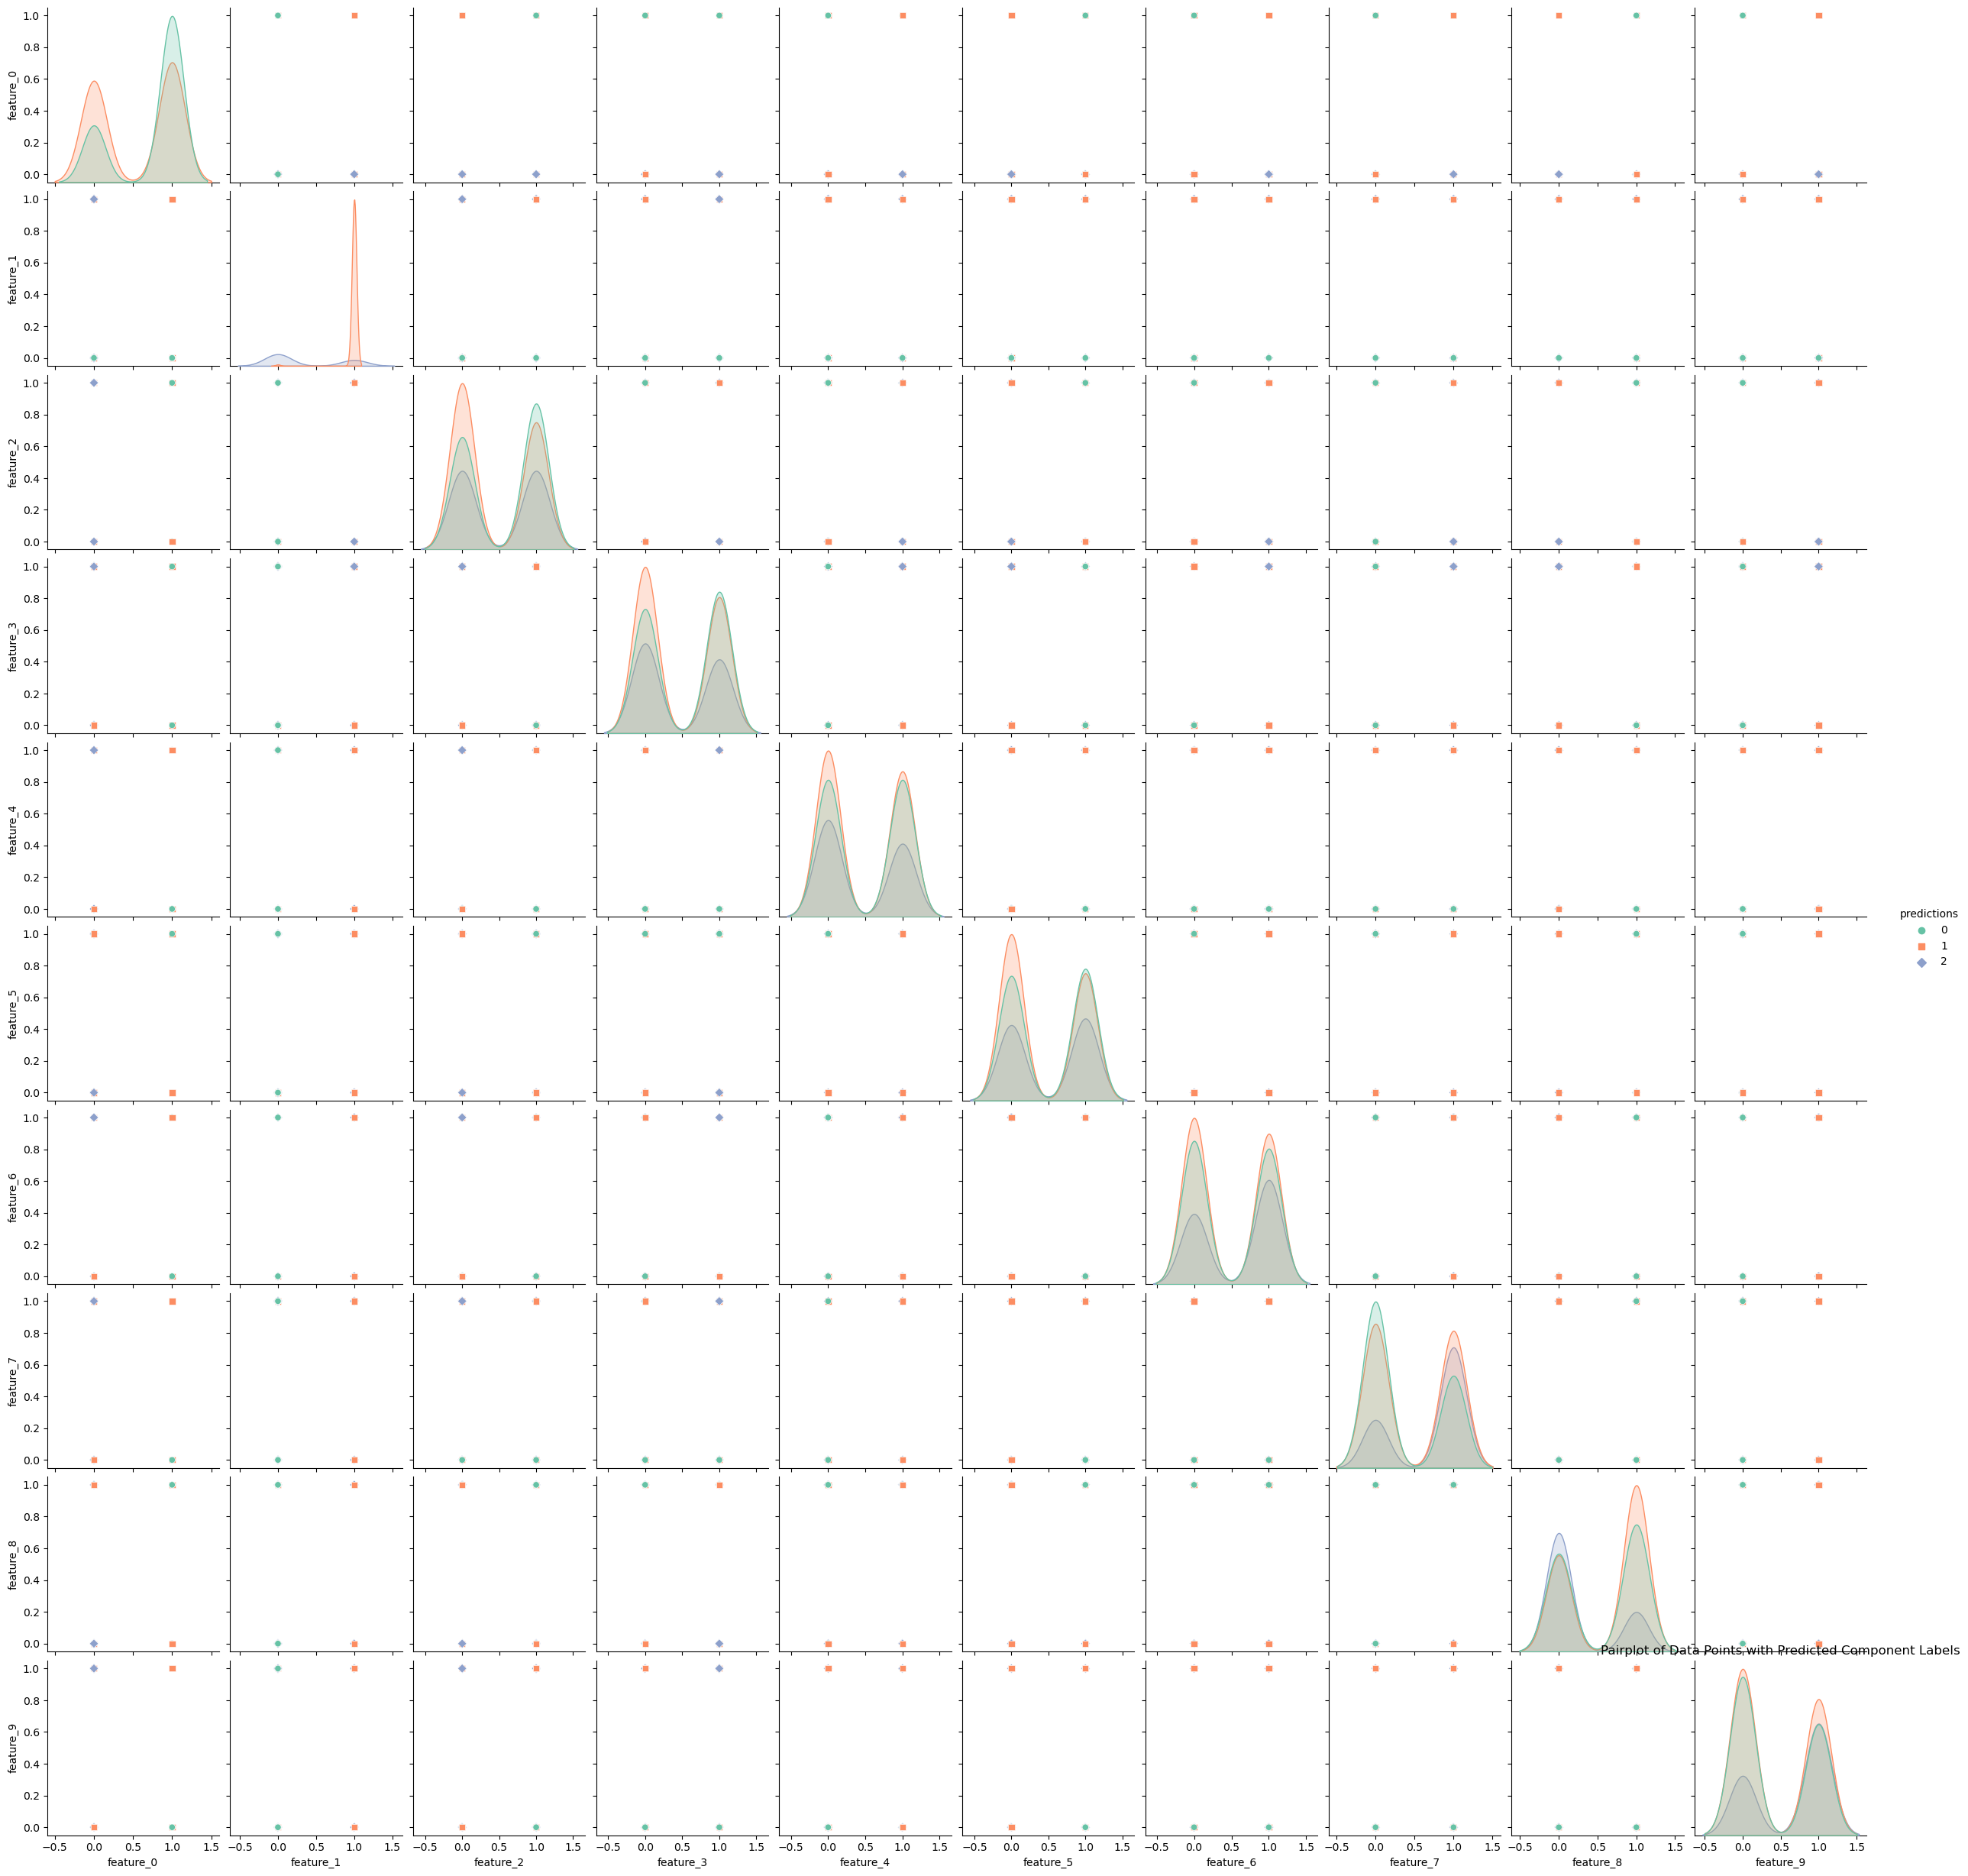

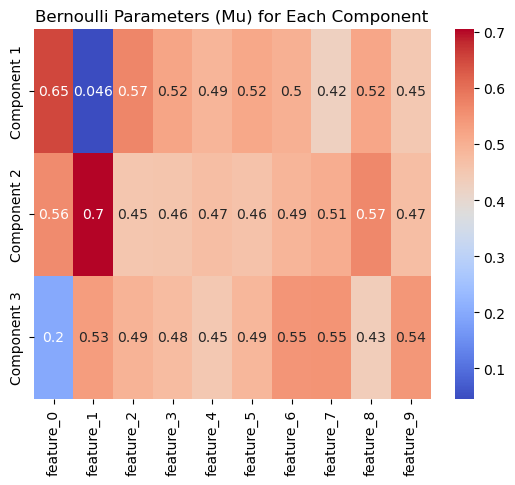

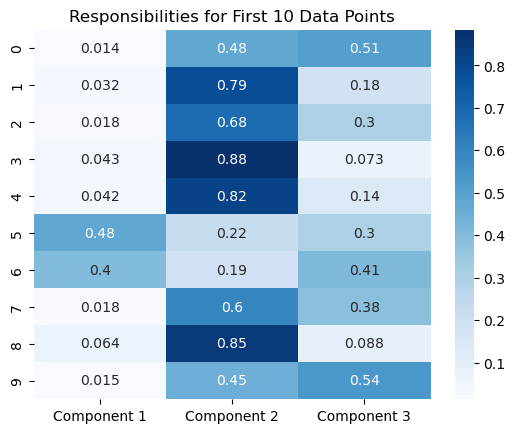

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random

# Set random seed for reproducibility
random.seed(42)

# Generating synthetic binary data (N = 600 samples, D = 10 features)
N, D = 600, 10
X = np.random.rand(N, D) > 0.5  # Binary data (True/False)

# Parameters for the Bernoulli mixture model
K = 3  # Number of components (clusters)
max_iter = 10  # Number of EM iterations

# Initialize parameters randomly
pi = np.ones(K) / K  # Mixing coefficients (uniform distribution)
mu = np.random.rand(K, D)  # Bernoulli parameters (means)
mu = mu / np.sum(mu, axis=1)[:, None]  # Normalize to get valid probabilities

# Helper function to compute the likelihood of x given the Bernoulli distribution
def bernoulli_likelihood(x, mu_k):
    return np.prod(mu_k**x * (1 - mu_k)**(1 - x), axis=1)

# E-step: Compute responsibilities (posterior probabilities)
def e_step(X, pi, mu):
    N, D = X.shape
    responsibilities = np.zeros((N, K))
    
    for k in range(K):
        # Likelihood for each component k (Bernoulli distribution)
        likelihood = bernoulli_likelihood(X, mu[k])
        responsibilities[:, k] = pi[k] * likelihood
    
    # Normalize responsibilities (to ensure they sum to 1)
    responsibilities_sum = responsibilities.sum(axis=1)[:, np.newaxis]
    responsibilities /= responsibilities_sum
    return responsibilities

# M-step: Update parameters based on responsibilities
def m_step(X, responsibilities):
    N, D = X.shape
    Nk = responsibilities.sum(axis=0)  # Effective number of points for each component
    
    # Update mixing coefficients (pi_k)
    pi_new = Nk / N
    
    # Update Bernoulli parameters (mu_k)
    mu_new = (responsibilities.T @ X) / Nk[:, None]
    
    return pi_new, mu_new

# EM algorithm: Iterate between E-step and M-step
for iteration in range(max_iter):
    # E-step
    responsibilities = e_step(X, pi, mu)
    
    # M-step
    pi, mu = m_step(X, responsibilities)
    
    print(f"Iteration {iteration + 1}:")
    print(f"Updated Mixing Coefficients: {pi}")
    print(f"Updated Mu (Bernoulli parameters for each component): {mu}")
    
# Visualize the results using Seaborn
# Visualizing the first few data points to see the clustering
responsibilities_max = responsibilities.argmax(axis=1)  # Assign each point to the most likely component

# Create a DataFrame for Seaborn visualization
import pandas as pd

data_df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(D)])
data_df['predictions'] = responsibilities_max

# Pairplot to visualize how data points are distributed across the features
sns.pairplot(data_df, hue='predictions', palette="Set2", markers=["o", "s", "D"])
plt.title("Pairplot of Data Points with Predicted Component Labels")
plt.show()

# Visualize the final component parameters (Bernoulli parameters)
sns.heatmap(mu, annot=True, cmap="coolwarm", xticklabels=[f'feature_{i}' for i in range(D)], yticklabels=[f'Component {i+1}' for i in range(K)])
plt.title("Bernoulli Parameters (Mu) for Each Component")
plt.show()

# Visualizing the distribution of responsibilities for the first 10 data points
sns.heatmap(responsibilities[:10], annot=True, cmap="Blues", xticklabels=[f'Component {i+1}' for i in range(K)])
plt.title("Responsibilities for First 10 Data Points")
plt.show()


Iteration 1:
Updated Mixing Coefficients: [0.3422258205780843, 0.3444871762676014, 0.3132870031543138]
Updated Mu (Bernoulli parameters for each component): [[0.4474220291046543, 0.6088434677188623, 0.47467902871459505, 0.43555698133628823, 0.4750678898511285, 0.6000992489146096, 0.4485433435615254, 0.600723291578834, 0.5089266601755369, 0.41316531275879925], [0.5120605453948719, 0.5210126670300633, 0.5704023914912615, 0.5520059154411826, 0.47070341481632266, 0.41539159321936797, 0.46602825078634413, 0.5744297404069729, 0.4506470560436993, 0.5492209970373139], [0.5973723849575227, 0.3845968530825141, 0.5406850661970364, 0.5025706800528938, 0.4743303845130901, 0.5102886389865782, 0.5829249054012473, 0.4358090121436824, 0.5285569545187856, 0.4822135503103287]]
Iteration 2:
Updated Mixing Coefficients: [0.3408752916370167, 0.3455363614091171, 0.3135883469538661]
Updated Mu (Bernoulli parameters for each component): [[0.4400958442458833, 0.5978095308235526, 0.4801991749722769, 0.4309362596

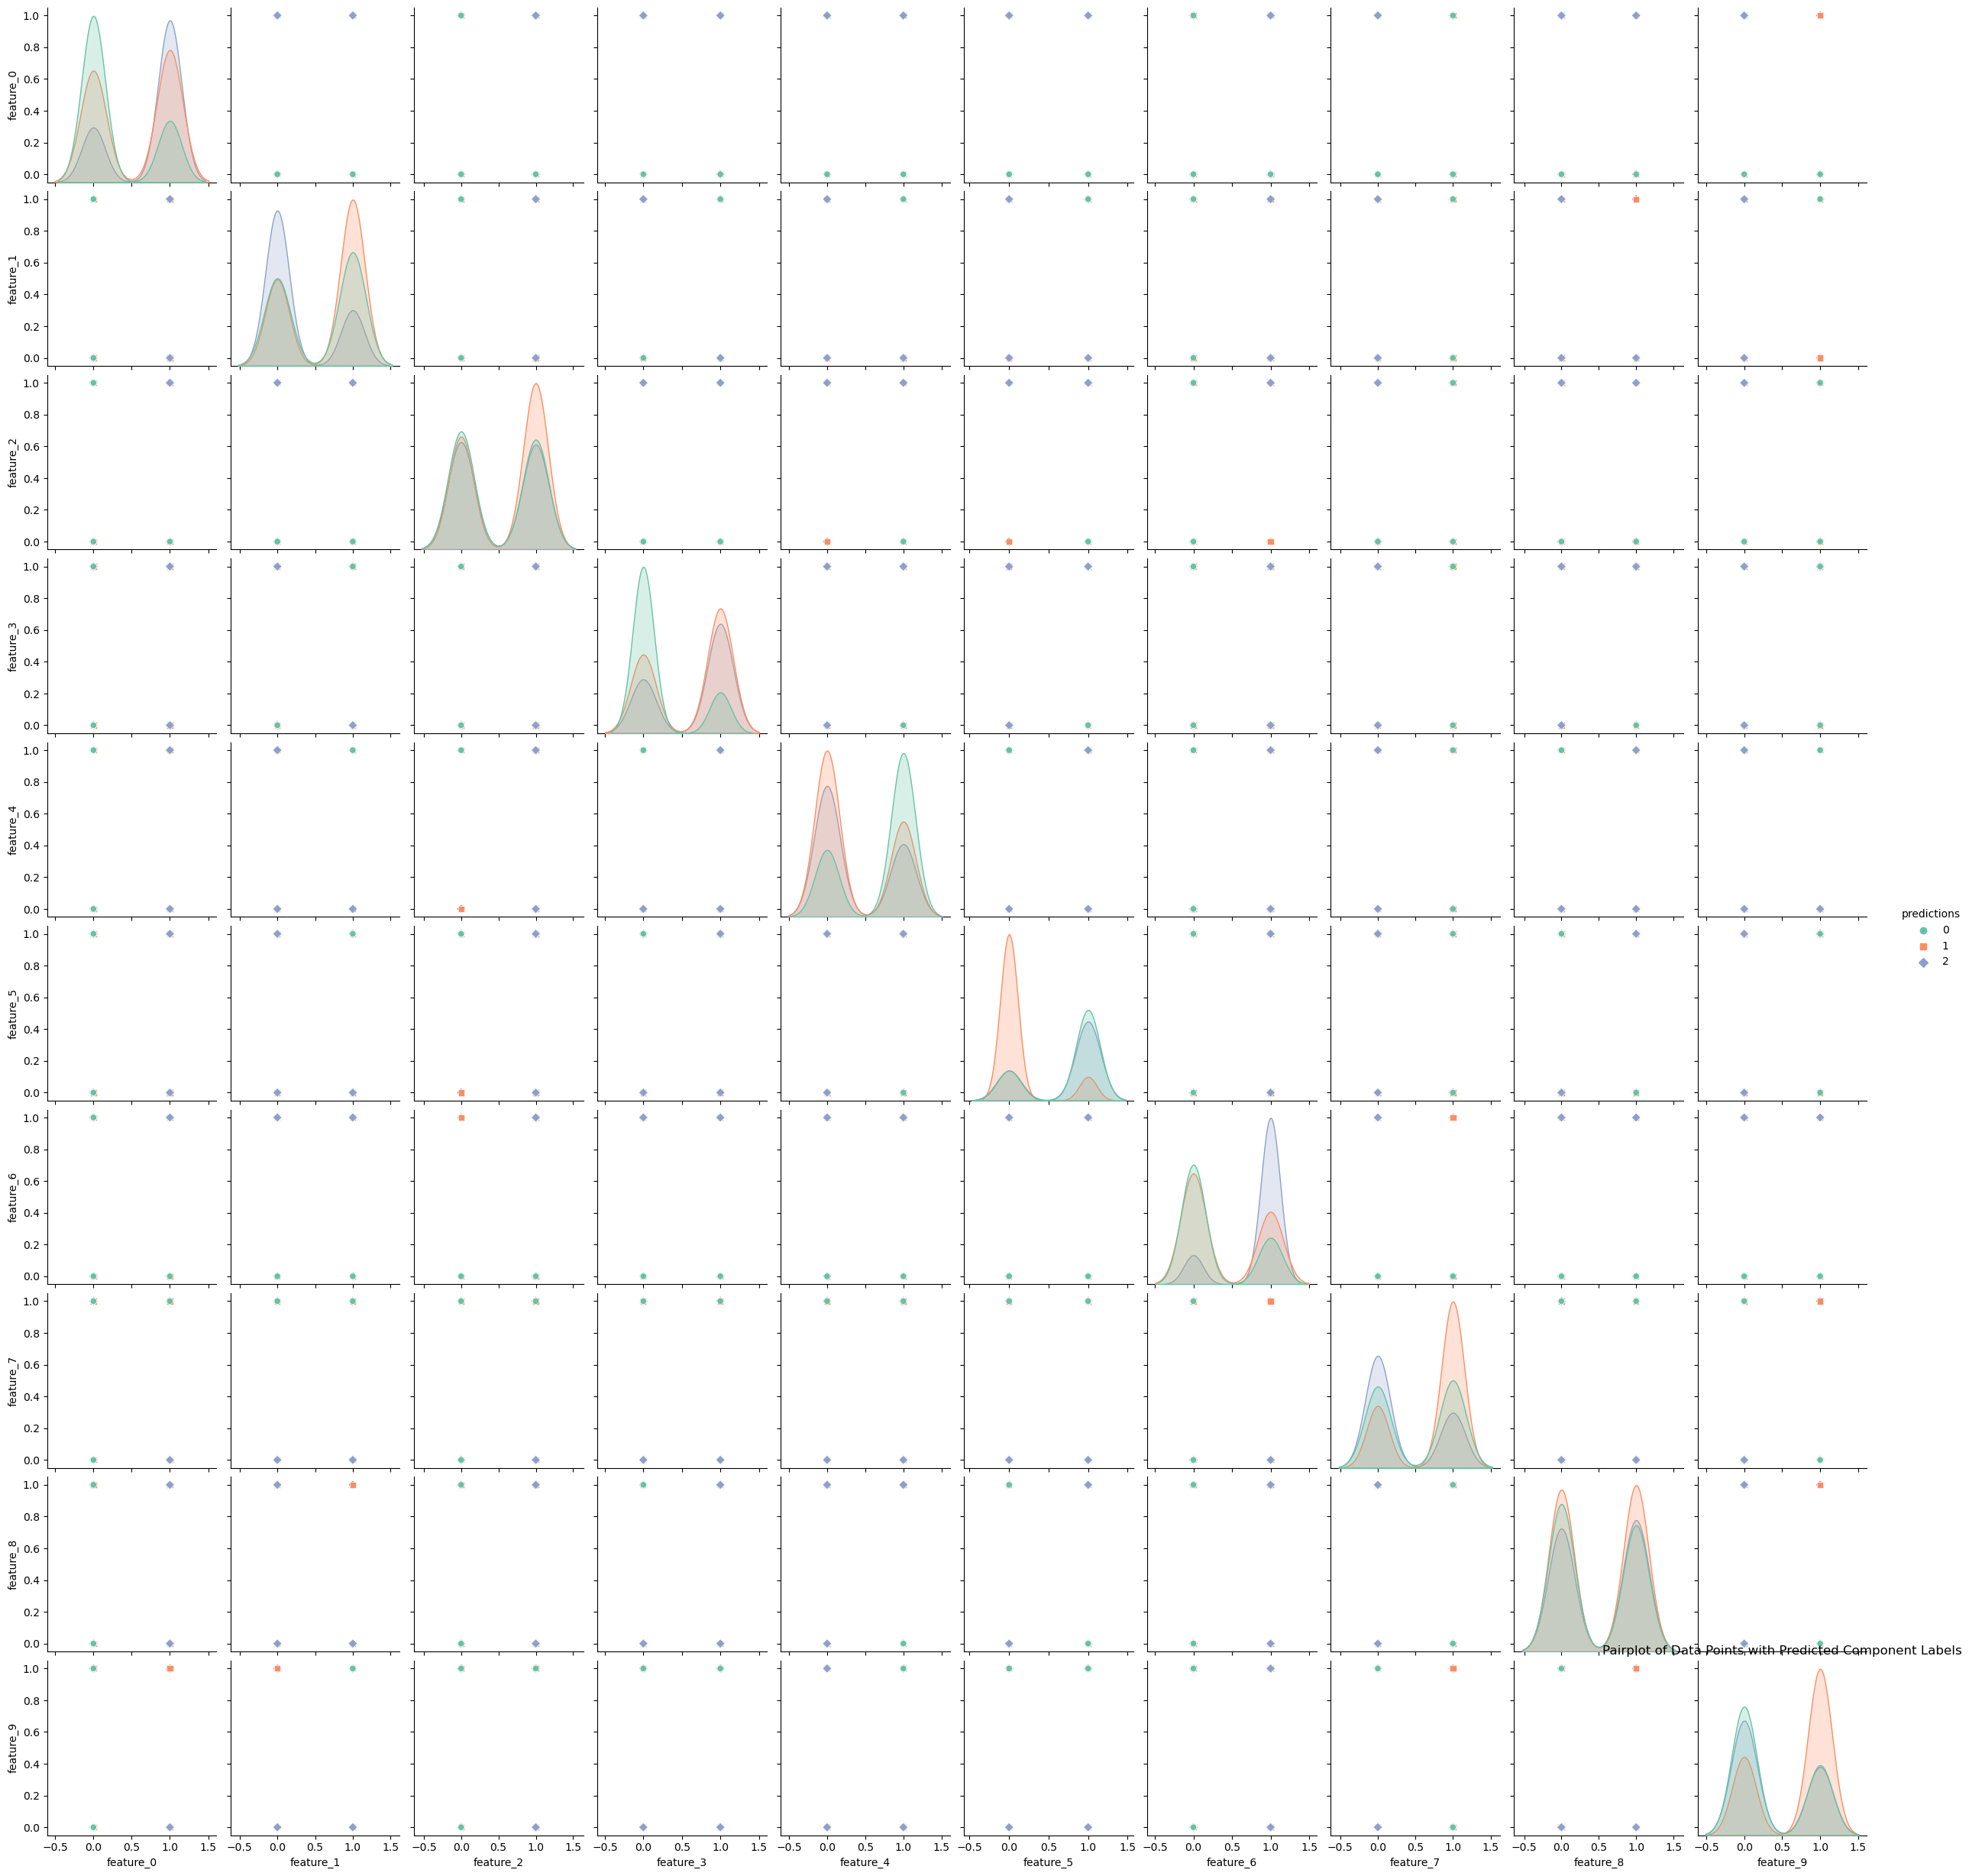

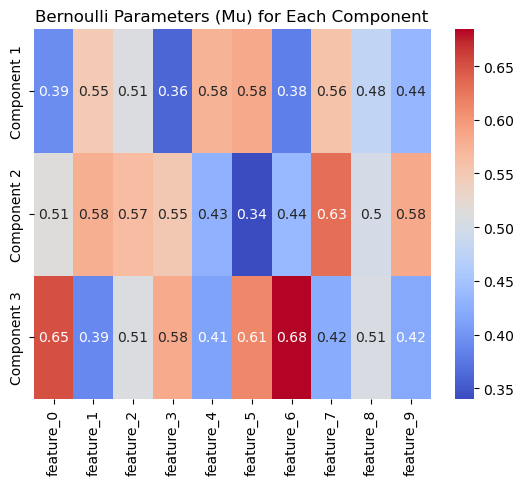

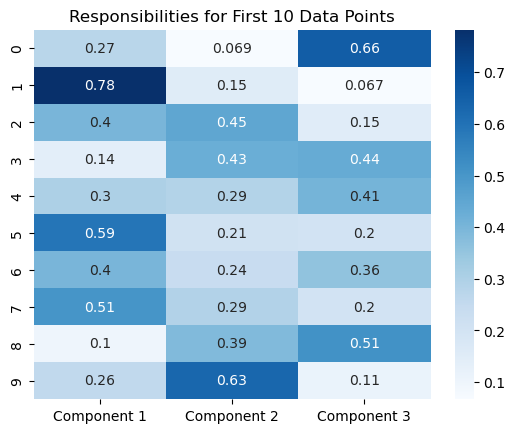

In [10]:
import random
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Set random seed for reproducibility
random.seed(42)

# Generate synthetic binary data (N = 600 samples, D = 10 features)
N, D = 600, 10
X = [[random.random() > 0.5 for _ in range(D)] for _ in range(N)]  # Binary data (True/False)

# Parameters for the Bernoulli mixture model
K = 3  # Number of components (clusters)
max_iter = 10  # Number of EM iterations

# Initialize parameters randomly
pi = [1 / K] * K  # Mixing coefficients (uniform distribution)
mu = [[random.uniform(0.25, 0.75) for _ in range(D)] for _ in range(K)]  # Bernoulli parameters (means)
mu = [[val / sum(mu[k]) for val in mu[k]] for k in range(K)]  # Normalize to get valid probabilities

# Helper function to compute the likelihood of x given the Bernoulli distribution
def bernoulli_likelihood(x, mu_k):
    likelihood = 1
    for i in range(len(x)):
        likelihood *= mu_k[i] ** x[i] * (1 - mu_k[i]) ** (1 - x[i])
    return likelihood

# E-step: Compute responsibilities (posterior probabilities)
def e_step(X, pi, mu):
    responsibilities = []
    for n in range(N):
        likelihoods = []
        for k in range(K):
            likelihood = bernoulli_likelihood(X[n], mu[k])
            likelihoods.append(pi[k] * likelihood)
        total_likelihood = sum(likelihoods)
        responsibilities.append([likelihood / total_likelihood for likelihood in likelihoods])
    return responsibilities

# M-step: Update parameters based on responsibilities
def m_step(X, responsibilities):
    Nk = [0] * K
    mu_new = [[0] * D for _ in range(K)]

    for n in range(N):
        for k in range(K):
            Nk[k] += responsibilities[n][k]
            for d in range(D):
                mu_new[k][d] += responsibilities[n][k] * X[n][d]

    # Normalize the parameters
    for k in range(K):
        for d in range(D):
            mu_new[k][d] /= Nk[k]

    pi_new = [Nk[k] / N for k in range(K)]
    return pi_new, mu_new

# EM algorithm: Iterate between E-step and M-step
for iteration in range(max_iter):
    # E-step
    responsibilities = e_step(X, pi, mu)
    
    # M-step
    pi, mu = m_step(X, responsibilities)
    
    print(f"Iteration {iteration + 1}:")
    print(f"Updated Mixing Coefficients: {pi}")
    print(f"Updated Mu (Bernoulli parameters for each component): {mu}")
    
# Visualize the results using Seaborn
# Assign each data point to the most likely component based on responsibilities
responsibilities_max = [max(range(K), key=lambda k: responsibilities[n][k]) for n in range(N)]

# Create a DataFrame for Seaborn visualization
data_df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(D)])
data_df['predictions'] = responsibilities_max

# Pairplot to visualize how data points are distributed across the features
sns.pairplot(data_df, hue='predictions', palette="Set2", markers=["o", "s", "D"])
plt.title("Pairplot of Data Points with Predicted Component Labels")
plt.show()

# Visualize the final component parameters (Bernoulli parameters)
sns.heatmap(mu, annot=True, cmap="coolwarm", xticklabels=[f'feature_{i}' for i in range(D)], yticklabels=[f'Component {i+1}' for i in range(K)])
plt.title("Bernoulli Parameters (Mu) for Each Component")
plt.show()

# Visualizing the distribution of responsibilities for the first 10 data points
sns.heatmap(responsibilities[:10], annot=True, cmap="Blues", xticklabels=[f'Component {i+1}' for i in range(K)])
plt.title("Responsibilities for First 10 Data Points")
plt.show()


## Expectation-Maximization (EM) Algorithm

The **Expectation-Maximization (EM)** algorithm is a general technique for finding maximum likelihood solutions in probabilistic models with latent variables (hidden variables). It iterates between two steps: the **E-step (Expectation)** and the **M-step (Maximization)**.

##$ Goal

The goal of the EM algorithm is to maximize the **log-likelihood function** $ \ln p(X|\theta) $, where $ X $ denotes the observed data and $ \theta $ represents the parameters of the model.

We define the **joint distribution** of the observed variables $ X $ and the latent variables $ Z $ as $ p(X, Z|\theta) $, and the **complete-data likelihood** is given by:

$$
p(X|\theta) = \sum_{Z} p(X, Z|\theta)
$$

Direct optimization of the **marginal likelihood** $ p(X|\theta) $ can be challenging, but optimizing the complete-data likelihood $ p(X, Z|\theta) $ is typically easier.

### Decomposition of the Log-Likelihood

To facilitate optimization, we introduce an auxiliary distribution $ q(Z) $ over the latent variables. We can then decompose the log-likelihood as follows:

$$
\ln p(X|\theta) = L(q, \theta) + \text{KL}(q || p)
$$

Where:

1. **Lower Bound (L)**:
   $$
   L(q, \theta) = \mathbb{E}_{q(Z)} \left[ \ln \frac{p(X, Z|\theta)}{q(Z)} \right]
   $$

2. **Kullback-Leibler Divergence (KL)**:
   $$
   \text{KL}(q || p) = - \mathbb{E}_{q(Z)} \left[ \ln \frac{q(Z)}{p(Z|X, \theta)} \right]
   $$

Since the **KL divergence** $ \text{KL}(q || p) $ is always non-negative, we know that:

$$
L(q, \theta) \leq \ln p(X|\theta)
$$

This implies that $ L(q, \theta) $ is a **lower bound** on the log-likelihood.

### EM Algorithm: Steps

1. **E-step (Expectation)**:
   In the E-step, we maximize the lower bound $ L(q, \theta) $ with respect to the distribution $ q(Z) $, while holding the parameters $ \theta $ fixed. The solution to this maximization is $ q(Z) = p(Z|X, \theta_{\text{old}}) $, i.e., we set the distribution of the latent variables equal to the posterior distribution.

2. **M-step (Maximization)**:
   In the M-step, we maximize the lower bound $ L(q, \theta) $ with respect to the parameters $ \theta $, while holding the distribution $ q(Z) $ fixed. This yields the updated parameters $ \theta_{\text{new}} $, and this step typically simplifies to maximizing the expected complete-data log-likelihood.

### Maximizing the Lower Bound

After the E-step, we substitute \( q(Z) = p(Z|X, \theta_{\text{old}}) \) into the lower bound:

$$
L(q, \theta) = \mathbb{E}_{q(Z)} \left[ \ln p(X, Z|\theta) \right] - \mathbb{E}_{q(Z)} \left[ \ln p(Z|X, \theta_{\text{old}}) \right]
$$

This can be rewritten as:

$$
L(q, \theta) = Q(\theta, \theta_{\text{old}}) + \text{const}
$$

Where:

$$
Q(\theta, \theta_{\text{old}}) = \sum_{Z} p(Z|X, \theta_{\text{old}}) \ln p(X, Z|\theta)
$$

### Conclusion

The EM algorithm iterates between the **E-step**, where we calculate the posterior distribution of the latent variables, and the **M-step**, where we update the parameters by maximizing the expected complete-data log-likelihood. Each iteration increases the log-likelihood, converging to a local maximum.

By this iterative process, the EM algorithm provides a method for finding maximum likelihood estimates when some of the variables in the model are latent.

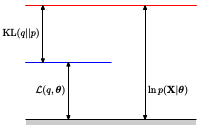

Fig.11 Illustration of the decomposition given by (9.70), which holds for any choice of distribution q(Z). Because the Kullback-Leibler divergence satisﬁes $ \text{KL}(q || p) $, we see that the quantity L(q, θ) is a lower bound on the log likelihood function ln p(X|θ).

$$
\ln p(X|\theta) = L(q, \theta) + \text{KL}(q || p)
$$

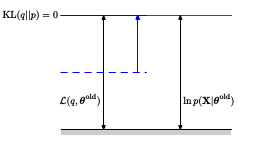

Fig.12 Illustration of the E step of the EM algorithm. The q distribution is set equal to the posterior distribution for the current parameter val- ues θ old , causing the lower bound to move up to the same value as the log like- lihood function, with the KL divergence vanishing.


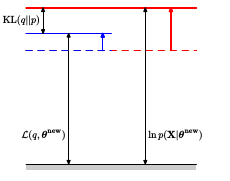

Fig.13 Illustration of the M step of the EM algorithm. The distribution q(Z) is held ﬁxed and the lower bound L(q, θ) is maximized with respect to the parameter vector θ to give a revised value θ new . Because the KL divergence is nonnegative, this causes the log likelihood ln p(X|θ) to increase by at least as much as the lower bound does.


## EM Algorithm and Its Operations

The **EM algorithm** alternates between computing a lower bound on the log likelihood for the current parameter values and maximizing this bound to obtain new parameter values. This process is described below.

### Overview of the EM Algorithm

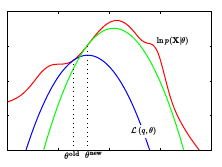

Fig. 14 The EM algorithm involves alternately computing a lower bound on the log likelihood for the current parameter values and then maximizing this bound to obtain the new parameter values. See the text for a full discussion.

In Fig.14, the **EM algorithm** involves the following steps:

1. We begin with an initial parameter value $ \theta^{\text{old}} $.
2. In the first **E-step**, we evaluate the posterior distribution over latent variables, which gives rise to a lower bound $ L(\theta, \theta^{\text{old}}) $.
3. This bound $ L(\theta, \theta^{\text{old}}) $ is tangent to the log-likelihood at $ \theta^{\text{old}} $, as shown by the blue curve.
4. The bound is convex and has a unique maximum (for mixture components from the exponential family).
5. In the **M-step**, we maximize this bound to obtain the new parameter value $ \theta^{\text{new}} $, which results in a larger value of the log-likelihood.

The process then repeats: the subsequent **E-step** computes a bound that is tangent at $ \theta^{\text{new}} $ (shown by the green curve), and the **M-step** maximizes this updated bound.

## Posterior Distribution

For independent, identically distributed (i.i.d.) data, where $ X = \{x_n\} $ and the latent variables are $ Z = \{z_n\} $, the posterior distribution is evaluated as:

$$
p(Z|X, \theta) = \prod_{n=1}^N p(z_n | x_n, \theta) = \prod_{n=1}^N p(x_n, z_n | \theta)
$$

This shows that the posterior distribution factorizes with respect to each data point $ x_n $, which simplifies the calculation of the responsibilities (or weights) of each mixture component for a particular data point.

## Maximization of Log Likelihood with Prior

If we introduce a prior $ p(\theta) $ over the parameters, we can maximize the **posterior** distribution $ p(\theta | X) $, using the decomposition of the log-posterior:

$$
\ln p(\theta | X) = \ln p(\theta, X) - \ln p(X)
$$

Using the decomposition of the likelihood function, we get:

$$
\ln p(\theta | X) = L(q, \theta) + \text{KL}(q || p) + \ln p(\theta) - \ln p(X)
$$

Here, $ \ln p(X) $ is a constant, and we can optimize this expression alternately with respect to $ q $ and $ \theta $. The **E-step** is unchanged, and the **M-step** is modified by the prior $ \ln p(\theta) $.

## Generalized EM (GEM) and ECM Algorithms

- **GEM Algorithm**: If the **M-step** is intractable, the **Generalized EM (GEM)** algorithm modifies the approach by only increasing the bound $ L(q, \theta) $, rather than maximizing it. The log-likelihood is guaranteed to increase with each complete EM cycle.

- **Expectation Conditional Maximization (ECM)**: This approach involves breaking the M-step into multiple constrained optimizations, where subsets of parameters are optimized one at a time while holding the others fixed.

## Incremental EM Algorithm

In the case of **independent data points**, we can use an **incremental EM algorithm** where, instead of processing all data points at once, we process one data point at a time in each **E-step** and **M-step**. This makes the algorithm more efficient, as each step requires only the updated responsibilities for the current data point. For instance, in the **M-step** for a Gaussian mixture, the update rule for the means $ \mu_k $ is:

$$
\mu_k^{\text{new}} = \mu_k^{\text{old}} + \frac{\gamma_{\text{new}}(z_{mk}) - \gamma_{\text{old}}(z_{mk})}{N_k} \left(x_m - \mu_k^{\text{old}}\right)
$$

where $ \gamma_{\text{new}}(z_{mk}) $ and $ \gamma_{\text{old}}(z_{mk}) $ are the updated and previous responsibilities, and $ N_k $ is the number of data points assigned to component $ k $.

The number of data points for component $ k $ is updated as:

$$
N_k^{\text{new}} = N_k^{\text{old}} + \gamma_{\text{new}}(z_{mk}) - \gamma_{\text{old}}(z_{mk})
$$

This incremental version is more efficient because the parameter updates happen after each data point, and it can converge faster than the batch version.

## Conclusion

The **EM algorithm** is a powerful tool for maximizing the log-likelihood function in probabilistic models with latent variables. By alternating between the **E-step** and **M-step**, the algorithm increases the likelihood at each step. Variants like **GEM** and **ECM** offer ways to handle intractable steps, and the **incremental EM** algorithm can speed up convergence by updating parameters after each data point.


Iteration 1, Log Likelihood: -1192.5583630827214
Iteration 2, Log Likelihood: -1185.4506612391788
Iteration 3, Log Likelihood: -1182.872914531519
Iteration 4, Log Likelihood: -1181.3653350862414
Iteration 5, Log Likelihood: -1180.4158225137498
Iteration 6, Log Likelihood: -1179.7877759819335
Iteration 7, Log Likelihood: -1179.3373229995232
Iteration 8, Log Likelihood: -1178.9820437095275
Iteration 9, Log Likelihood: -1178.6741963793536
Iteration 10, Log Likelihood: -1178.3834322553923
Iteration 11, Log Likelihood: -1178.0862967404682
Iteration 12, Log Likelihood: -1177.7606777599135
Iteration 13, Log Likelihood: -1177.3856054459957
Iteration 14, Log Likelihood: -1176.9509807292357
Iteration 15, Log Likelihood: -1176.4806436560418
Iteration 16, Log Likelihood: -1176.036723418053
Iteration 17, Log Likelihood: -1175.6483360618302
Iteration 18, Log Likelihood: -1175.2715932827932
Iteration 19, Log Likelihood: -1174.8585716914727
Iteration 20, Log Likelihood: -1174.385460112199
Iteration 21

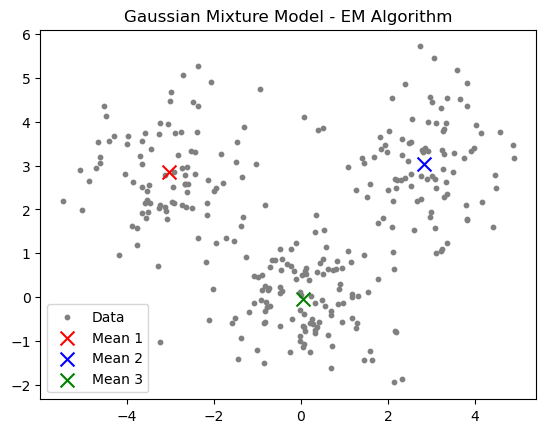

In [11]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

class GMM:
    def __init__(self, K, max_iter=100, tol=1e-6):
        """
        Initialize the Gaussian Mixture Model (GMM).
        
        Parameters:
            K (int): The number of Gaussian components.
            max_iter (int): Maximum number of iterations for the EM algorithm.
            tol (float): Convergence tolerance for the log-likelihood.
        """
        self.K = K  # Number of Gaussian components
        self.max_iter = max_iter  # Maximum number of iterations
        self.tol = tol  # Convergence tolerance
        
    def initialize_parameters(self, X):
        """
        Initialize the parameters of the GMM, including weights, means, and covariances.
        
        Parameters:
            X (numpy.ndarray): The input data, shape (N, D) where N is the number of samples and D is the number of features.
        """
        N, D = X.shape  # N = number of samples, D = number of features
        
        # Initialize weights (mixing coefficients) randomly
        self.weights = np.ones(self.K) / self.K
        
        # Initialize means randomly from the data
        random_idx = np.random.choice(N, self.K, replace=False)
        self.means = X[random_idx]
        
        # Initialize covariances as identity matrices
        self.covariances = [np.eye(D) for _ in range(self.K)]
        
    def e_step(self, X):
        """
        Perform the E-step: compute the responsibilities (posterior probabilities).
        
        Parameters:
            X (numpy.ndarray): The input data, shape (N, D).
        
        Returns:
            numpy.ndarray: The responsibilities, shape (N, K).
        """
        N = X.shape[0]
        responsibilities = np.zeros((N, self.K))
        
        # Calculate the responsibilities (posterior probabilities)
        for k in range(self.K):
            pdf = multivariate_normal.pdf(X, mean=self.means[k], cov=self.covariances[k])
            responsibilities[:, k] = self.weights[k] * pdf
        
        # Normalize responsibilities
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        return responsibilities
    
    def m_step(self, X, responsibilities):
        """
        Perform the M-step: update the parameters (weights, means, covariances).
        
        Parameters:
            X (numpy.ndarray): The input data, shape (N, D).
            responsibilities (numpy.ndarray): The responsibilities, shape (N, K).
        """
        N, D = X.shape
        
        # Update weights
        Nk = responsibilities.sum(axis=0)
        self.weights = Nk / N
        
        # Update means
        self.means = (responsibilities.T @ X) / Nk[:, np.newaxis]
        
        # Update covariances
        self.covariances = []
        for k in range(self.K):
            diff = X - self.means[k]
            cov = np.dot(responsibilities[:, k] * diff.T, diff) / Nk[k]
            self.covariances.append(cov)
        
    def log_likelihood(self, X):
        """
        Compute the log-likelihood of the data under the current parameters.
        
        Parameters:
            X (numpy.ndarray): The input data, shape (N, D).
        
        Returns:
            float: The log-likelihood of the data.
        """
        N = X.shape[0]
        log_likelihood = 0
        for k in range(self.K):
            pdf = multivariate_normal.pdf(X, mean=self.means[k], cov=self.covariances[k])
            log_likelihood += self.weights[k] * pdf
        return np.sum(np.log(log_likelihood))
    
    def fit(self, X):
        """
        Fit the GMM to the data using the EM algorithm.
        
        Parameters:
            X (numpy.ndarray): The input data, shape (N, D).
        """
        # Initialize parameters
        self.initialize_parameters(X)
        
        # Initialize log likelihood
        prev_log_likelihood = -np.inf
        
        # EM algorithm loop
        for iteration in range(self.max_iter):
            # E-step: Compute responsibilities
            responsibilities = self.e_step(X)
            
            # M-step: Update parameters
            self.m_step(X, responsibilities)
            
            # Compute log likelihood
            log_likelihood = self.log_likelihood(X)
            print(f"Iteration {iteration+1}, Log Likelihood: {log_likelihood}")
            
            # Check for convergence
            if np.abs(log_likelihood - prev_log_likelihood) < self.tol:
                print("Convergence reached!")
                break
            prev_log_likelihood = log_likelihood


# Generate synthetic data for GMM
np.random.seed(42)
N = 300  # Number of samples
D = 2  # Number of features
K = 3  # Number of Gaussian components

# Define true parameters for the GMM
means = np.array([[3, 3], [0, 0], [-3, 3]])
covariances = [np.eye(D) for _ in range(K)]
weights = np.array([0.3, 0.4, 0.3])

# Generate the data points
X = np.vstack([np.random.multivariate_normal(means[i], covariances[i], int(weights[i] * N))
               for i in range(K)])

# Fit GMM to the data
gmm = GMM(K=K)
gmm.fit(X)

# Visualize the results
plt.scatter(X[:, 0], X[:, 1], c='gray', s=10, label='Data')
colors = ['red', 'blue', 'green']
for i in range(K):
    plt.scatter(gmm.means[i, 0], gmm.means[i, 1], c=colors[i], marker='x', s=100, label=f'Mean {i+1}')
plt.title('Gaussian Mixture Model - EM Algorithm')
plt.legend()
plt.show()


Iteration 1, Log Likelihood: -1192.5583630827214
Iteration 2, Log Likelihood: -1185.4506612391788
Iteration 3, Log Likelihood: -1182.8729145315192
Iteration 4, Log Likelihood: -1181.3653350862414
Iteration 5, Log Likelihood: -1180.41582251375
Iteration 6, Log Likelihood: -1179.7877759819335
Iteration 7, Log Likelihood: -1179.3373229995234
Iteration 8, Log Likelihood: -1178.9820437095275
Iteration 9, Log Likelihood: -1178.6741963793538
Iteration 10, Log Likelihood: -1178.3834322553923
Iteration 11, Log Likelihood: -1178.0862967404682
Iteration 12, Log Likelihood: -1177.7606777599135
Iteration 13, Log Likelihood: -1177.3856054459957
Iteration 14, Log Likelihood: -1176.9509807292357
Iteration 15, Log Likelihood: -1176.4806436560418
Iteration 16, Log Likelihood: -1176.0367234180533
Iteration 17, Log Likelihood: -1175.6483360618304
Iteration 18, Log Likelihood: -1175.2715932827932
Iteration 19, Log Likelihood: -1174.8585716914727
Iteration 20, Log Likelihood: -1174.3854601121993
Iteration 2

ValueError: If using all scalar values, you must pass an index

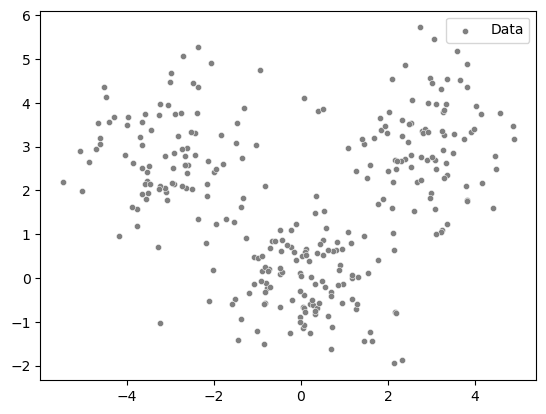

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

class GMM:
    def __init__(self, K, max_iter=100, tol=1e-6):
        """
        Initialize the Gaussian Mixture Model (GMM).
        
        Parameters:
            K (int): The number of Gaussian components.
            max_iter (int): Maximum number of iterations for the EM algorithm.
            tol (float): Convergence tolerance for the log-likelihood.
        """
        self.K = K  # Number of Gaussian components
        self.max_iter = max_iter  # Maximum number of iterations
        self.tol = tol  # Convergence tolerance
        
    def initialize_parameters(self, X):
        """
        Initialize the parameters of the GMM, including weights, means, and covariances.
        
        Parameters:
            X (numpy.ndarray): The input data, shape (N, D) where N is the number of samples and D is the number of features.
        """
        N, D = X.shape  # N = number of samples, D = number of features
        
        # Initialize weights (mixing coefficients) randomly
        self.weights = np.ones(self.K) / self.K
        
        # Initialize means randomly from the data
        random_idx = np.random.choice(N, self.K, replace=False)
        self.means = X[random_idx]
        
        # Initialize covariances as identity matrices
        self.covariances = [np.eye(D) for _ in range(self.K)]
        
    def e_step(self, X):
        """
        Perform the E-step: compute the responsibilities (posterior probabilities).
        
        Parameters:
            X (numpy.ndarray): The input data, shape (N, D).
        
        Returns:
            numpy.ndarray: The responsibilities, shape (N, K).
        """
        N = X.shape[0]
        responsibilities = np.zeros((N, self.K))
        
        # Calculate the responsibilities (posterior probabilities)
        for k in range(self.K):
            diff = X - self.means[k]
            inv_cov = np.linalg.inv(self.covariances[k])
            exponent = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
            normalizer = np.sqrt(np.linalg.det(2 * np.pi * self.covariances[k]))
            responsibilities[:, k] = self.weights[k] * np.exp(exponent) / normalizer
        
        # Normalize responsibilities
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        return responsibilities
    
    def m_step(self, X, responsibilities):
        """
        Perform the M-step: update the parameters (weights, means, covariances).
        
        Parameters:
            X (numpy.ndarray): The input data, shape (N, D).
            responsibilities (numpy.ndarray): The responsibilities, shape (N, K).
        """
        N, D = X.shape
        
        # Update weights
        Nk = responsibilities.sum(axis=0)
        self.weights = Nk / N
        
        # Update means
        self.means = (responsibilities.T @ X) / Nk[:, np.newaxis]
        
        # Update covariances
        self.covariances = []
        for k in range(self.K):
            diff = X - self.means[k]
            cov = np.dot(responsibilities[:, k] * diff.T, diff) / Nk[k]
            self.covariances.append(cov)
        
    def log_likelihood(self, X):
        """
        Compute the log-likelihood of the data under the current parameters.
        
        Parameters:
            X (numpy.ndarray): The input data, shape (N, D).
        
        Returns:
            float: The log-likelihood of the data.
        """
        N = X.shape[0]
        log_likelihood = 0
        for k in range(self.K):
            diff = X - self.means[k]
            inv_cov = np.linalg.inv(self.covariances[k])
            exponent = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
            normalizer = np.sqrt(np.linalg.det(2 * np.pi * self.covariances[k]))
            log_likelihood += self.weights[k] * np.exp(exponent) / normalizer
        return np.sum(np.log(log_likelihood))
    
    def fit(self, X):
        """
        Fit the GMM to the data using the EM algorithm.
        
        Parameters:
            X (numpy.ndarray): The input data, shape (N, D).
        """
        # Initialize parameters
        self.initialize_parameters(X)
        
        # Initialize log likelihood
        prev_log_likelihood = -np.inf
        
        # EM algorithm loop
        for iteration in range(self.max_iter):
            # E-step: Compute responsibilities
            responsibilities = self.e_step(X)
            
            # M-step: Update parameters
            self.m_step(X, responsibilities)
            
            # Compute log likelihood
            log_likelihood = self.log_likelihood(X)
            print(f"Iteration {iteration+1}, Log Likelihood: {log_likelihood}")
            
            # Check for convergence
            if np.abs(log_likelihood - prev_log_likelihood) < self.tol:
                print("Convergence reached!")
                break
            prev_log_likelihood = log_likelihood


# Generate synthetic data for GMM
np.random.seed(42)
N = 300  # Number of samples
D = 2  # Number of features
K = 3  # Number of Gaussian components

# Define true parameters for the GMM
means = np.array([[3, 3], [0, 0], [-3, 3]])
covariances = [np.eye(D) for _ in range(K)]
weights = np.array([0.3, 0.4, 0.3])

# Generate the data points
X = np.vstack([np.random.multivariate_normal(means[i], covariances[i], int(weights[i] * N))
               for i in range(K)])

# Fit GMM to the data
gmm = GMM(K=K)
gmm.fit(X)

# Visualize the results
sns.scatterplot(x=X[:, 0], y=X[:, 1], color='gray', s=20, label='Data')
colors = ['red', 'blue', 'green']
for i in range(K):
    sns.scatterplot(x=gmm.means[i, 0], y=gmm.means[i, 1], color=colors[i], marker='x', s=100, label=f'Mean {i+1}')
plt.title('Gaussian Mixture Model - EM Algorithm')
plt.legend()
plt.show()


Iteration 1, Log Likelihood: -1199.5177545213596
Iteration 2, Log Likelihood: -1196.4961668943838
Iteration 3, Log Likelihood: -1195.6341366920244
Iteration 4, Log Likelihood: -1195.338206801886
Iteration 5, Log Likelihood: -1195.2000461842545
Iteration 6, Log Likelihood: -1195.0976174195469
Iteration 7, Log Likelihood: -1194.99521573815
Iteration 8, Log Likelihood: -1194.8841596229372
Iteration 9, Log Likelihood: -1194.7652041087897
Iteration 10, Log Likelihood: -1194.6427603504399
Iteration 11, Log Likelihood: -1194.5221477863247
Iteration 12, Log Likelihood: -1194.4078017753848
Iteration 13, Log Likelihood: -1194.3022481806422
Iteration 14, Log Likelihood: -1194.2058334520655
Iteration 15, Log Likelihood: -1194.1169586509327
Iteration 16, Log Likelihood: -1194.032450839436
Iteration 17, Log Likelihood: -1193.9477697479654
Iteration 18, Log Likelihood: -1193.856853751139
Iteration 19, Log Likelihood: -1193.7514417162527
Iteration 20, Log Likelihood: -1193.6196096935669
Iteration 21, 

ValueError: If using all scalar values, you must pass an index

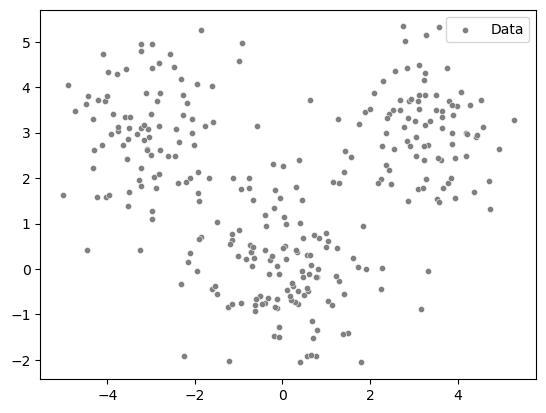

In [13]:
import random
import math
import seaborn as sns
import matplotlib.pyplot as plt


class GMM:
    def __init__(self, K, max_iter=100, tol=1e-6):
        """
        Initialize the Gaussian Mixture Model (GMM).
        
        Parameters:
            K (int): The number of Gaussian components.
            max_iter (int): Maximum number of iterations for the EM algorithm.
            tol (float): Convergence tolerance for the log-likelihood.
        """
        self.K = K  # Number of Gaussian components
        self.max_iter = max_iter  # Maximum number of iterations
        self.tol = tol  # Convergence tolerance
        
    def initialize_parameters(self, X):
        """
        Initialize the parameters of the GMM, including weights, means, and covariances.
        
        Parameters:
            X (list): The input data, where each element is a data point [x1, x2, ...]
        """
        N = len(X)  # Number of data points
        D = len(X[0])  # Number of features
        
        # Initialize weights (mixing coefficients) randomly
        self.weights = [1.0 / self.K] * self.K
        
        # Initialize means randomly from the data
        random_idx = random.sample(range(N), self.K)
        self.means = [X[i] for i in random_idx]
        
        # Initialize covariances as identity matrices
        self.covariances = [[[1.0 if i == j else 0.0 for j in range(D)] for i in range(D)] for _ in range(self.K)]
        
    def e_step(self, X):
        """
        Perform the E-step: compute the responsibilities (posterior probabilities).
        
        Parameters:
            X (list): The input data, where each element is a data point [x1, x2, ...].
        
        Returns:
            list: The responsibilities, where each element is a list of responsibilities for each component.
        """
        N = len(X)
        responsibilities = [[0.0] * self.K for _ in range(N)]
        
        # Calculate the responsibilities (posterior probabilities)
        for i in range(N):
            for k in range(self.K):
                diff = [X[i][j] - self.means[k][j] for j in range(len(X[i]))]
                inv_cov = self.inverse(self.covariances[k])
                exponent = -0.5 * sum(diff[j] * sum(inv_cov[j][m] * diff[m] for m in range(len(diff))) for j in range(len(diff)))
                normalizer = math.sqrt(self.determinant(self.covariances[k]) * (2 * math.pi) ** len(X[i]))
                responsibilities[i][k] = self.weights[k] * math.exp(exponent) / normalizer
            
            # Normalize responsibilities
            total_responsibility = sum(responsibilities[i])
            if total_responsibility > 0:
                responsibilities[i] = [r / total_responsibility for r in responsibilities[i]]
        
        return responsibilities
    
    def m_step(self, X, responsibilities):
        """
        Perform the M-step: update the parameters (weights, means, covariances).
        
        Parameters:
            X (list): The input data, where each element is a data point [x1, x2, ...].
            responsibilities (list): The responsibilities, where each element is a list of responsibilities for each component.
        """
        N = len(X)
        D = len(X[0])
        
        # Update weights
        Nk = [sum(responsibilities[i][k] for i in range(N)) for k in range(self.K)]
        self.weights = [nk / N for nk in Nk]
        
        # Update means
        for k in range(self.K):
            weighted_sum = [sum(responsibilities[i][k] * X[i][j] for i in range(N)) for j in range(D)]
            self.means[k] = [weighted_sum[j] / Nk[k] for j in range(D)]
        
        # Update covariances
        for k in range(self.K):
            cov = [[0.0] * D for _ in range(D)]
            for i in range(N):
                diff = [X[i][j] - self.means[k][j] for j in range(D)]
                for j in range(D):
                    for m in range(D):
                        cov[j][m] += responsibilities[i][k] * diff[j] * diff[m]
            self.covariances[k] = [[cov[j][m] / Nk[k] for m in range(D)] for j in range(D)]
        
    def log_likelihood(self, X):
        """
        Compute the log-likelihood of the data under the current parameters.
        
        Parameters:
            X (list): The input data, where each element is a data point [x1, x2, ...].
        
        Returns:
            float: The log-likelihood of the data.
        """
        N = len(X)
        log_likelihood = 0
        for i in range(N):
            likelihood = 0
            for k in range(self.K):
                diff = [X[i][j] - self.means[k][j] for j in range(len(X[i]))]
                inv_cov = self.inverse(self.covariances[k])
                exponent = -0.5 * sum(diff[j] * sum(inv_cov[j][m] * diff[m] for m in range(len(diff))) for j in range(len(diff)))
                normalizer = math.sqrt(self.determinant(self.covariances[k]) * (2 * math.pi) ** len(X[i]))
                likelihood += self.weights[k] * math.exp(exponent) / normalizer
            log_likelihood += math.log(likelihood)
        return log_likelihood
    
    def inverse(self, matrix):
        """
        Compute the inverse of a matrix using Gaussian elimination.
        
        Parameters:
            matrix (list of list): A square matrix.
        
        Returns:
            list of list: The inverse matrix.
        """
        size = len(matrix)
        # Create an augmented matrix
        augmented = [row[:] + [1.0 if i == j else 0.0 for j in range(size)] for i, row in enumerate(matrix)]
        
        for i in range(size):
            # Make the diagonal element 1 by dividing the whole row
            diag = augmented[i][i]
            for j in range(2 * size):
                augmented[i][j] /= diag
            
            # Eliminate all other elements in the column
            for j in range(size):
                if j != i:
                    factor = augmented[j][i]
                    for k in range(2 * size):
                        augmented[j][k] -= factor * augmented[i][k]
        
        # Extract the inverse matrix
        return [row[size:] for row in augmented]
    
    def determinant(self, matrix):
        """
        Compute the determinant of a matrix using recursion (Laplace expansion).
        
        Parameters:
            matrix (list of list): A square matrix.
        
        Returns:
            float: The determinant of the matrix.
        """
        size = len(matrix)
        if size == 1:
            return matrix[0][0]
        
        det = 0
        for i in range(size):
            # Create a minor matrix by excluding the first row and ith column
            minor = [row[:i] + row[i + 1:] for row in matrix[1:]]
            det += ((-1) ** i) * matrix[0][i] * self.determinant(minor)
        return det
    
    def fit(self, X):
        """
        Fit the GMM to the data using the EM algorithm.
        
        Parameters:
            X (list): The input data, where each element is a data point [x1, x2, ...].
        """
        self.initialize_parameters(X)
        prev_log_likelihood = -float('inf')
        
        for iteration in range(self.max_iter):
            # E-step: Compute responsibilities
            responsibilities = self.e_step(X)
            
            # M-step: Update parameters
            self.m_step(X, responsibilities)
            
            # Compute log likelihood
            log_likelihood = self.log_likelihood(X)
            print(f"Iteration {iteration+1}, Log Likelihood: {log_likelihood}")
            
            # Check for convergence
            if abs(log_likelihood - prev_log_likelihood) < self.tol:
                print("Convergence reached!")
                break
            prev_log_likelihood = log_likelihood


# Generate synthetic data for GMM
random.seed(42)
N = 300  # Number of samples
D = 2  # Number of features
K = 3  # Number of Gaussian components

# Define true parameters for the GMM
means = [[3, 3], [0, 0], [-3, 3]]
covariances = [[[1.0, 0.0], [0.0, 1.0]] for _ in range(K)]
weights = [0.3, 0.4, 0.3]

# Generate the data points
X = []
for k in range(K):
    n_samples = int(weights[k] * N)
    for _ in range(n_samples):
        sample = [random.gauss(means[k][0], math.sqrt(covariances[k][0][0])),
                  random.gauss(means[k][1], math.sqrt(covariances[k][1][1]))]
        X.append(sample)

# Fit GMM to the data
gmm = GMM(K=K)
gmm.fit(X)

# Visualize the results
sns.scatterplot(x=[x[0] for x in X], y=[x[1] for x in X], color='gray', s=20, label='Data')
colors = ['red', 'blue', 'green']
for i in range(K):
    sns.scatterplot(x=gmm.means[i][0], y=gmm.means[i][1], color=colors[i], marker='x', s=100, label=f'Mean {i+1}')
plt.title('Gaussian Mixture Model - EM Algorithm')
plt.legend()
plt.show()
